### Mechanical Power Vital File Reinforcement Learning 
* Sangwon Baek / SNUH / Vital Lab 
* Jan 30th 2024 

In [1]:
import vitaldb

import pandas as pd
from pandas import Timestamp, Timedelta
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
import seaborn as sns
import pytz
from itertools import chain
from tqdm import tqdm
import datetime

import re
import os
import glob
import random
from collections import defaultdict
import gc  # Garbage Collector
import sys

from joblib import Parallel, delayed

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Display first 50 rows of dataframe
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

#Set Global Matplotlib parameters for font 
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12

# import d3rlpy algorithms
import d3rlpy
from d3rlpy.algos import DiscreteCQLConfig, CQLConfig, CQL
from d3rlpy.dataset import MDPDataset
from d3rlpy.preprocessing import StandardObservationScaler, MinMaxActionScaler, StandardRewardScaler
from d3rlpy.ope import FQE, FQEConfig, DiscreteFQE

# from d3rlpy.metrics.scorer import evaluate_on_environment, discounted_sum_of_advantage_scorer

# import rtbgym and gym
import gym
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"GPU: {device}")

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

/tmp/ipykernel_2645027/47251558.py:5: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use a new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be reported on the Dask issue tracker
https://github.com/dask/dask/issues 

To disable this warning in the future, set dask config:

    # via Python
    >>> dask.config.set({'dataframe.query-planning-warning': False})

    # via CLI
    dask config set dataframe.query-pla

GPU: cuda:0


In [2]:
def collect_file_npz(years):
    # Initialize a dictionary to hold filenames and file paths for each year
    file_names, file_paths = {}, {}

    # Initialize an empty list to store all file paths across years
    all_filenames, all_file_paths = [], []

    # Iterate over each year, get filenames, and count .vital files
    for year in years:
        path = f'../Data/VitalNPZ/{year}/'
        try:
            filenames = os.listdir(path)
        except FileNotFoundError:
            print(f"Directory not found: {path}")
            continue

        # Store filenames and file paths for the current year
        file_names[year] = filenames
        year_file_paths = [os.path.join(path, filename) for filename in filenames]
        file_paths[year] = year_file_paths

        # Extend all_file_paths list with file paths from the current year
        all_file_paths.extend(year_file_paths)
        all_filenames.extend(filenames)

        # Count and print the number of .npz files
        npz_file_count = len([f for f in filenames if f.endswith('.npz')])
        print(f'Got a total of {npz_file_count} vital files for MP research in 20{year}')

    return file_names, file_paths, all_filenames, all_file_paths

def stratified_sampling_npz(directory_paths, sample_size=1):
    def extract_op_room(filename):
        return filename.split('_')[0]

    file_names = {}
    for year, path in directory_paths.items():
        filenames = os.listdir(path)
        file_names[year] = [os.path.join(f'../Data/VitalNPZ/{year}/', fname) for fname in filenames]  # Prepend the path to filenames

    # Group filenames by year and operation room
    stratified_groups = defaultdict(lambda: defaultdict(list))
    for year, filenames in file_names.items():
        for fname in filenames:
            op_room = extract_op_room(fname)
            stratified_groups[year][op_room].append(fname)

    # Perform stratified random sampling
    sampled_filenames = []
    for year, op_rooms in stratified_groups.items():
        for op_room, fnames in op_rooms.items():
            if len(fnames) >= sample_size:
                sampled_filenames.extend(random.sample(fnames, sample_size))
            else:
                sampled_filenames.extend(fnames)
    
    # Print the number of files sampled
    print(f"Sampled {len(sampled_filenames)} files")
    return sampled_filenames

def reformat_filenames_vital(original_filename):
    # Remove the '.vital' extension from the original filename
    base_filename = original_filename[:-6]  # Assuming '.vital' is always the extension and is 6 characters long
    
    # Split the base filename to extract the necessary parts
    parts = base_filename.split('_')
    if len(parts) > 1:
        # Extract the year part (first two digits after the underscore)
        year_part = parts[1][:2]
        # Construct the new filename, appending '_MP.npz' at the end
        new_filename = f"../Data/VitalNPZ/{year_part}/{base_filename}_MP.npz"
        return new_filename
    else:
        # If the filename doesn't match the expected pattern, append '_MP.vital' to the original base filename
        return f"{base_filename}_MP.npz"
    
def get_filtered_reformatted_filenames(df, threshold):
    # Filter DataFrame based on MP Missing Rate threshold
    filtered_df = df[df['MP Missing Rate'] <= threshold]
    
    # Apply reformatting to each filename in the filtered DataFrame
    reformatted_filenames = filtered_df['File Name'].apply(reformat_filenames_vital).tolist()
    
    return reformatted_filenames

In [3]:
def extract_year_from_path(file_path):
    year_match = re.search(r'/(\d{2})/', file_path)
    return "20" + str(year_match.group(1)) if year_match else "Unknown"

def rename_column(name):
    # Handle the combined MP case
    if 'MP_COMBINED_60' in name:
        return 'Combined_MP'
    if 'MP_METHOD_60' in name:
        return 'MP_Method'
    # Use regex to find the metric name between "/" and " ("
    match = re.search(r'/(?P<metric_name>.+?) \(', name)
    if match:
        return match.group('metric_name')
    
    # If no pattern matches, return the original name (or you could choose to handle it differently)
    return name

def extract_file_id(file_path):  
    # Extract the segment between the last '/' and '_MP'
    file_id = re.search(r'/([^/]+)_MP', file_path)
    return file_id.group(1) if file_id else "Unknown"

def load_single_npz_file(file_path):
    try:
        with np.load(file_path, allow_pickle=True, mmap_mode='r') as data:
            vital_array = data['vital_data']
            track_names = data['track_names']

        track_names = np.insert(track_names, 0, "Time")
        filtered_columns = [name for name in track_names if (name.startswith('Mechanical Power') and name not in ["Mechanical Power 60/MP_SIMPLIFIED_60", "Mechanical Power 60/MP_SURROGATE_60", "Mechanical Power 60/MP_METHOD_60"]) or name == 'Time']

        # Identify indexes of filtered_columns in track_names to directly use them for creating the DataFrame
        filtered_columns_indexes = [i for i, name in enumerate(track_names) if name in filtered_columns]
        
        # Create a DataFrame with only the filtered columns from the vital_array
        processed_df = pd.DataFrame(vital_array[:, filtered_columns_indexes], columns=[track_names[i] for i in filtered_columns_indexes])

        processed_df = processed_df.rename(columns=lambda name: rename_column(name))
        processed_df['File_ID'] = extract_file_id(file_path)
        
        columns_order = ['File_ID'] + [col for col in processed_df.columns if col not in ['File_ID', 'Terminal_Index']]
        processed_df = processed_df[columns_order]

        # Remove rows where all columns except for 'File_ID' and 'Time' have missing values
        cols_to_check = processed_df.columns.difference(['File_ID', 'Time'])
        processed_df = processed_df.dropna(subset=cols_to_check, how='all')

        # Additionally, drop all rows where 'Combined_MP' column is missing
        processed_df = processed_df.dropna(subset=['Combined_MP'])

        # Explicit garbage collection
        del vital_array, track_names  # Delete variables that are no longer needed
        gc.collect()  # Invoke garbage collector

        return processed_df
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
    
def get_column_data(df, search_string):
    matched_columns = df.columns[df.columns.str.contains(search_string)]
    return df[matched_columns].dropna()

def process_all_npz_files(file_paths):
    # Process files in parallel and return the concatenated DataFrame of results
    dfs = Parallel(n_jobs=os.cpu_count())(
        delayed(load_single_npz_file)(fp) for fp in tqdm(file_paths, desc="Processing NPZ Files", file=sys.stdout)
    )
    # Filter out any None results due to errors
    dfs_filtered = [df for df in dfs if df is not None]
    # Concatenate all DataFrames into a single DataFrame if not empty
    if dfs_filtered:
        return pd.concat(dfs_filtered, ignore_index=True)
    return pd.DataFrame()  # Return an empty DataFrame if no data

# def process_all_npz_files_in_batches(file_paths, batch_size=10000):
#     # Split file_paths into chunks of batch_size
#     chunks = [file_paths[x:x+batch_size] for x in range(0, len(file_paths), batch_size)]
#     combined_df = pd.DataFrame()
    
#     for chunk in tqdm(chunks, desc="Processing Chunks"):
#         batch_df = process_files_in_batch(chunk)
#         combined_df = pd.concat([combined_df, batch_df], ignore_index=True)
    
#     return combined_df

In [4]:
def preprocess_demographic_data(filepath):
    # Load the demographic data
    demographic_df = pd.read_csv(filepath)
    
    # Remove 'MP Missing Rate' and 'OPID' columns
    demographic_df.drop(['MP Missing Rate', 'OPID'], axis=1, inplace=True)
    
    # Drop rows where 'age' is NaN
    demographic_df.dropna(subset=['age'], inplace=True)
    
    # Filter out rows where 'age' is less than 10
    demographic_df = demographic_df[demographic_df['age'] >= 10]
    
    # Drop rows where either 'height' or 'weight' does not exist (is NaN)
    demographic_df.dropna(subset=['height', 'weight'], inplace=True)
    
    # Convert 'age' from float to int
    demographic_df['age'] = demographic_df['age'].astype(int)
    
    # Change 'sex' values ("M" to 1; "F" to 0)
    demographic_df['sex'] = demographic_df['sex'].map({'M': 1, 'F': 0})

    # Remove 'vital' from the 'File_ID' column
    if 'File_ID' in demographic_df.columns:
        demographic_df['File_ID'] = demographic_df['File_ID'].str.replace('.vital', '', regex=False)
    
    return demographic_df

def plot_demographics(demographic_df):

    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")
    
    # Define a function to filter the middle 98% of a given column
    def filter_mid(column):
        lower_bound, upper_bound = column.quantile([0.01, 0.99])
        return column[(column >= lower_bound) & (column <= upper_bound)]

    # Apply the filter to age, height, and weight
    filtered_age = filter_mid(demographic_df['age'])
    filtered_height = filter_mid(demographic_df['height'])
    filtered_weight = filter_mid(demographic_df['weight'])

    # Histogram for Age
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_age, kde=True, color='black')
    plt.title('Histogram of Age')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(filtered_age.min(), filtered_age.max() + 1, 5))
    plt.show()

    # Histogram for Height
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_height, kde=True, color='green')
    plt.title('Histogram of Height')
    plt.xlabel('Height (cm)')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(filtered_height.min(), filtered_height.max() + 1, 5))
    plt.show()

    # Histogram for Weight
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_weight, kde=True, color='purple')
    plt.title('Histogram of Weight')
    plt.xlabel('Weight (kg)')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(filtered_weight.min(), filtered_weight.max() + 1, 5))
    plt.show()
    
    # Bar Plot for Sex remains unchanged as it's categorical and not affected by outlier cropping
    plt.figure(figsize=(10, 6))
    sex_counts = demographic_df['sex'].value_counts()
    sns.barplot(x=sex_counts.index, y=sex_counts.values, palette=['red', 'blue'])
    plt.title('Bar Plot of Sex')
    plt.xlabel('Sex')
    plt.ylabel('Count')
    plt.xticks(ticks=range(len(sex_counts)), labels=['Male' if x==1 else 'Female' for x in sex_counts.index])
    plt.show()



In [5]:
def calculate_overall_median_iqr(merged_df):
    # Aggregate unique predicted_Combined_MP values per File_ID
    unique_predicted_per_file = merged_df.drop_duplicates(subset=['File_ID', 'predicted_Combined_MP'])
    
    # Calculate median and IQR from these unique values
    overall_median = unique_predicted_per_file['predicted_Combined_MP'].median()
    Q1 = unique_predicted_per_file['predicted_Combined_MP'].quantile(0.25)
    Q3 = unique_predicted_per_file['predicted_Combined_MP'].quantile(0.75)
    overall_iqr = Q3 - Q1

    # Print the results
    print(f"Overall Median of Unique Predicted Combined_MP: {overall_median}")
    print(f"Overall IQR of Unique Predicted Combined_MP: {overall_iqr}")    
    
    return overall_median, overall_iqr

def plot_MP_histogram(merged_df):

    # Check if 'Combined_MP' is in the DataFrame
    if 'Combined_MP' not in merged_df.columns:
        print("The DataFrame does not contain 'Combined_MP'. Please ensure predictions have been made.")
        return

    # Remove duplicates to ensure each file_id is represented once
    unique_file_id_df = merged_df.drop_duplicates(subset=['File_ID'])

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(unique_file_id_df['Combined_MP'], bins=100, color='blue', edgecolor='black')
    plt.title('Distribution of Combined_MP for Unique File_IDs')
    plt.xlabel('Combined_MP')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def plot_regression_results(merged_df):
    """
    Plots the actual vs. predicted Combined_MP values from the regression analysis.
    
    Parameters:
    - merged_df: DataFrame containing both actual and predicted Combined_MP values.
    """
    # Scatter plot of actual vs. predicted Combined_MP
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Combined_MP', y='predicted_Combined_MP', data=merged_df, alpha=0.6)
    
    # Calculate limits for the plot
    min_val = min(merged_df['Combined_MP'].min(), merged_df['predicted_Combined_MP'].min())
    max_val = max(merged_df['Combined_MP'].max(), merged_df['predicted_Combined_MP'].max())
    
    # Draw line for perfect predictions
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    plt.title('Original vs. Adjusted MP')
    plt.xlabel('Original MP (unadjusted)')
    plt.ylabel('Adjusted MP (age, height, sex)')
    plt.grid(True)
    plt.show()

In [6]:
def create_reward_group(demographic_df, combined_df):
    merged_df = pd.merge(combined_df, demographic_df, on='File_ID', how='left')
    merged_df.dropna(subset=['Combined_MP', 'age', 'sex', 'height'], inplace=True)
    
    merged_df['sex'] = merged_df['sex'].astype(int)
    merged_df['age'] = merged_df['age'].astype(int)
    merged_df['height'] = merged_df['height'].round(1)
    
    age_bins = [0, 40, 60, 80, float('inf')]
    age_labels = ['~40', '40~60', '60~80', '80~']
    merged_df['age_group'] = pd.cut(merged_df['age'], bins=age_bins, labels=age_labels, right=False)
    
    # Apply height bins and labels based on sex directly within the apply method
    def apply_height_group(row):
        if row['sex'] == 0:  # Female
            bins = [0, 150, 160, 170, float('inf')]
            labels = ['<150', '150~160', '160~170', '>170']
        else:  # Male
            bins = [0, 160, 170, 180, float('inf')]
            labels = ['<160', '160~170', '170~180', '>180']
        # Find the index of the bin to which the height belongs
        bin_index = np.digitize(row['height'], bins) - 1  # Adjust index
        return labels[bin_index]

    merged_df['height_group'] = merged_df.apply(apply_height_group, axis=1)
    
    # Construct reward_group combining sex, age_group, and height_group
    merged_df['reward_group'] = merged_df.apply(lambda row: f"{('F' if row['sex'] == 0 else 'M')}_{row['age_group']}_{row['height_group']}", axis=1)
    
    # Map each unique reward_group to an ID
    group_mapping = {group: idx for idx, group in enumerate(merged_df['reward_group'].unique(), start=1)}
    merged_df['reward_group_id'] = merged_df['reward_group'].map(group_mapping)

    return merged_df

def create_action_groups(df):
    check_columns = ['RR', 'TV', 'PEEP']
    df = df.dropna(subset=check_columns).copy()

    # Define bins for each action column
    rr_bins = [-np.inf, 5, 10, 15, 20, np.inf]
    tv_bins = [-np.inf, 0.1, 0.3, 0.5, np.inf]
    peep_bins = [-np.inf, 5, 8, np.inf]
    
    # Define labels for the bins (optional, for clarity)
    rr_labels = ['~5', '5~10', '10~15', '15~20', '20~']
    tv_labels = ['~0.1', '0.1~0.3', '0.3~0.5', '0.5~']
    peep_labels = ['<5', '5~8', '>8']
    
    # Categorize each action column into bins
    df['RR_group'] = pd.cut(df['RR'], bins=rr_bins, labels=rr_labels)
    df['TV_group'] = pd.cut(df['TV'], bins=tv_bins, labels=tv_labels)
    df['PEEP_group'] = pd.cut(df['PEEP'], bins=peep_bins, labels=peep_labels)
    
    # Combine categorized groups into a single column to represent action groups
    df['action_groups'] = df['RR_group'].astype(str) + "_" + df['TV_group'].astype(str) + "_" + df['PEEP_group'].astype(str)

    # Assign numbers to each unique action_group to create action_group_ids
    df['action_group_ids'], _ = pd.factorize(df['action_groups'])

    return df

def create_subgroups(demographic_df, combined_df):
    temp_df = create_reward_group(demographic_df, combined_df)
    df = create_action_groups(temp_df)
    return df

def calculate_subgroup_statistics(merged_df):
    # Ensure 'Combined_MP' is in a numeric data type
    merged_df['Combined_MP'] = pd.to_numeric(merged_df['Combined_MP'], errors='coerce')
    
    # Group by 'group' and calculate the requested statistics for 'Combined_MP'
    group_stats = merged_df.groupby('reward_group')['Combined_MP'].quantile([0.25, 0.75]).unstack()

    # Create a dictionary to store the results
    stats_dict = {}
    
    # Populate the dictionary with the group as the key and a list of [Q1, Q3] as the value
    for group in group_stats.index:
        stats_dict[group] = [group_stats.loc[group, 0.25], group_stats.loc[group, 0.75]]
    
    return stats_dict

def assign_dynamic_rewards(row, reward_criteria):
    # Extract the group for this row
    group = row['reward_group']
    
    # Extract the Q1 and Q3 values for this group from the reward criteria
    q1, q3 = reward_criteria.get(group, [None, None])
    
    # Initialize reward to 0
    reward = 0

    combined_mp = row['Combined_MP']

    # Check if the group is not found in the criteria, or Q1/Q3 values are missing
    if pd.isnull(q1) or pd.isnull(q3):
        return 0  # Adjust this as needed
    
    # Calculate the reward based on distance from Q1 and Q3
    if combined_mp < q1:
        # Calculate the distance from Q1 and assign penalty accordingly
        distance = q1 - combined_mp
        reward = -(distance/2)  # Caps the penalty to -4 for distance >= 4
    elif combined_mp > q3:
        # Calculate the distance from Q3 and assign penalty accordingly
        distance = combined_mp - q3
        reward = -min(distance, 5)  # Caps the penalty to -5 for distance >= 5
    
    return reward

def get_dataset(df, reward_criteria):

    # Columns to check for NaN values
    check_columns = ['MV', 'RR', 'TV', 'PEEP', 'Peak Pressure', 'Plateau Pressure', 'F', 'CO2', 'Compliance', 'Combined_MP']
    
    # Drop rows where any NaN values exist in the specified columns
    df_cleaned = df.dropna(subset=check_columns).copy()

    # Observation columns
    observation_columns = ['MV', 'RR', 'TV', 'PEEP', 'Peak Pressure', 'Plateau Pressure', 'F', 'CO2', 'Compliance']
    observations = df_cleaned[observation_columns].to_numpy()
    
    # Use action_group_ids for actions
    actions = df_cleaned['action_group_ids'].to_numpy().reshape(-1, 1)
    
    # Apply the function to each row
    df_cleaned['reward'] = df_cleaned.apply(lambda row: assign_dynamic_rewards(row, reward_criteria), axis=1)
    rewards = df_cleaned['reward'].to_numpy().reshape(-1, 1)

    # Initialize 'Terminal_Index' to 0 for all rows and mark the last occurrence as terminal
    df_cleaned['Terminal_Index'] = 0
    last_occurrences = df_cleaned.groupby('File_ID').tail(1).index
    df_cleaned.loc[last_occurrences, 'Terminal_Index'] = 1
    terminals = df_cleaned['Terminal_Index'].to_numpy().reshape(-1, 1)

    return df_cleaned, observations, actions, rewards, terminals

In [7]:
years = range(17, 24)
# Get sampled file paths through stratified sampling
directory_paths = {year: f'../Data/VitalNPZ/{year}/' for year in range(17, 24)}
sampled_file_paths = stratified_sampling_npz(directory_paths, sample_size=10)
sampled_file_ids = [extract_file_id(fp) for fp in sampled_file_paths]
file_names, file_paths, all_filenames, all_file_paths = collect_file_npz(years)
print(f"Total number of files: {len(all_file_paths)}")

# Read missing rate files.csv and save afe mr_files_df 
mr_files_df = pd.read_csv('../Results/Missing_Rate_Files.csv')
necessary_file_paths = get_filtered_reformatted_filenames(mr_files_df, 0.2)
print(f"File paths after filtering: {len(necessary_file_paths)}")

# Load demographic data
demographic_df = preprocess_demographic_data("ExcelFiles/Demographic_data_vitals.csv")

Sampled 2297 files
Got a total of 4384 vital files for MP research in 2017
Got a total of 5465 vital files for MP research in 2018
Got a total of 6724 vital files for MP research in 2019
Got a total of 7545 vital files for MP research in 2020
Got a total of 8938 vital files for MP research in 2021
Got a total of 9776 vital files for MP research in 2022
Got a total of 3993 vital files for MP research in 2023
Total number of files: 46825
File paths after filtering: 45465


In [8]:
combined_df = process_all_npz_files(necessary_file_paths) 

Processing NPZ Files: 100%|██████████| 45465/45465 [13:30<00:00, 56.10it/s]


In [9]:
# action_group_id_counts = action_df['action_group_ids'].value_counts().sort_index()
# action_group_id_mapping = action_df[['action_groups', 'action_group_ids']].drop_duplicates().set_index('action_group_ids').sort_index()
# action_group_counts = pd.merge(action_group_id_counts, action_group_id_mapping, how='outer', on='action_group_ids')
# action_group_counts.to_csv("ExcelFiles/Action_group_counts.csv")
# action_group_counts

In [10]:
merged_df = create_subgroups(demographic_df, combined_df)
MP_Reward = calculate_subgroup_statistics(merged_df)

df_dataset, observations, actions, rewards, terminals = get_dataset(merged_df, MP_Reward)  
print(observations.shape, actions.shape, rewards.shape, terminals.shape)

# Cast data to more memory-efficient types
observations = observations.astype(np.float32)
actions = actions.astype(np.int32)  
rewards = rewards.astype(np.float32)  
terminals = terminals.astype(np.int32)  

# Creating the dataset with memory-efficient data types
dataset = MDPDataset(
    observations=observations,
    actions=actions,
    rewards=rewards,
    terminals=terminals
)

(47558405, 9) (47558405, 1) (47558405, 1) (47558405, 1)
2024-03-15 16:12.21 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(9,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2024-03-15 16:12.21 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-03-15 16:12.21 [info     ] Action size has been automatically determined. action_size=60


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

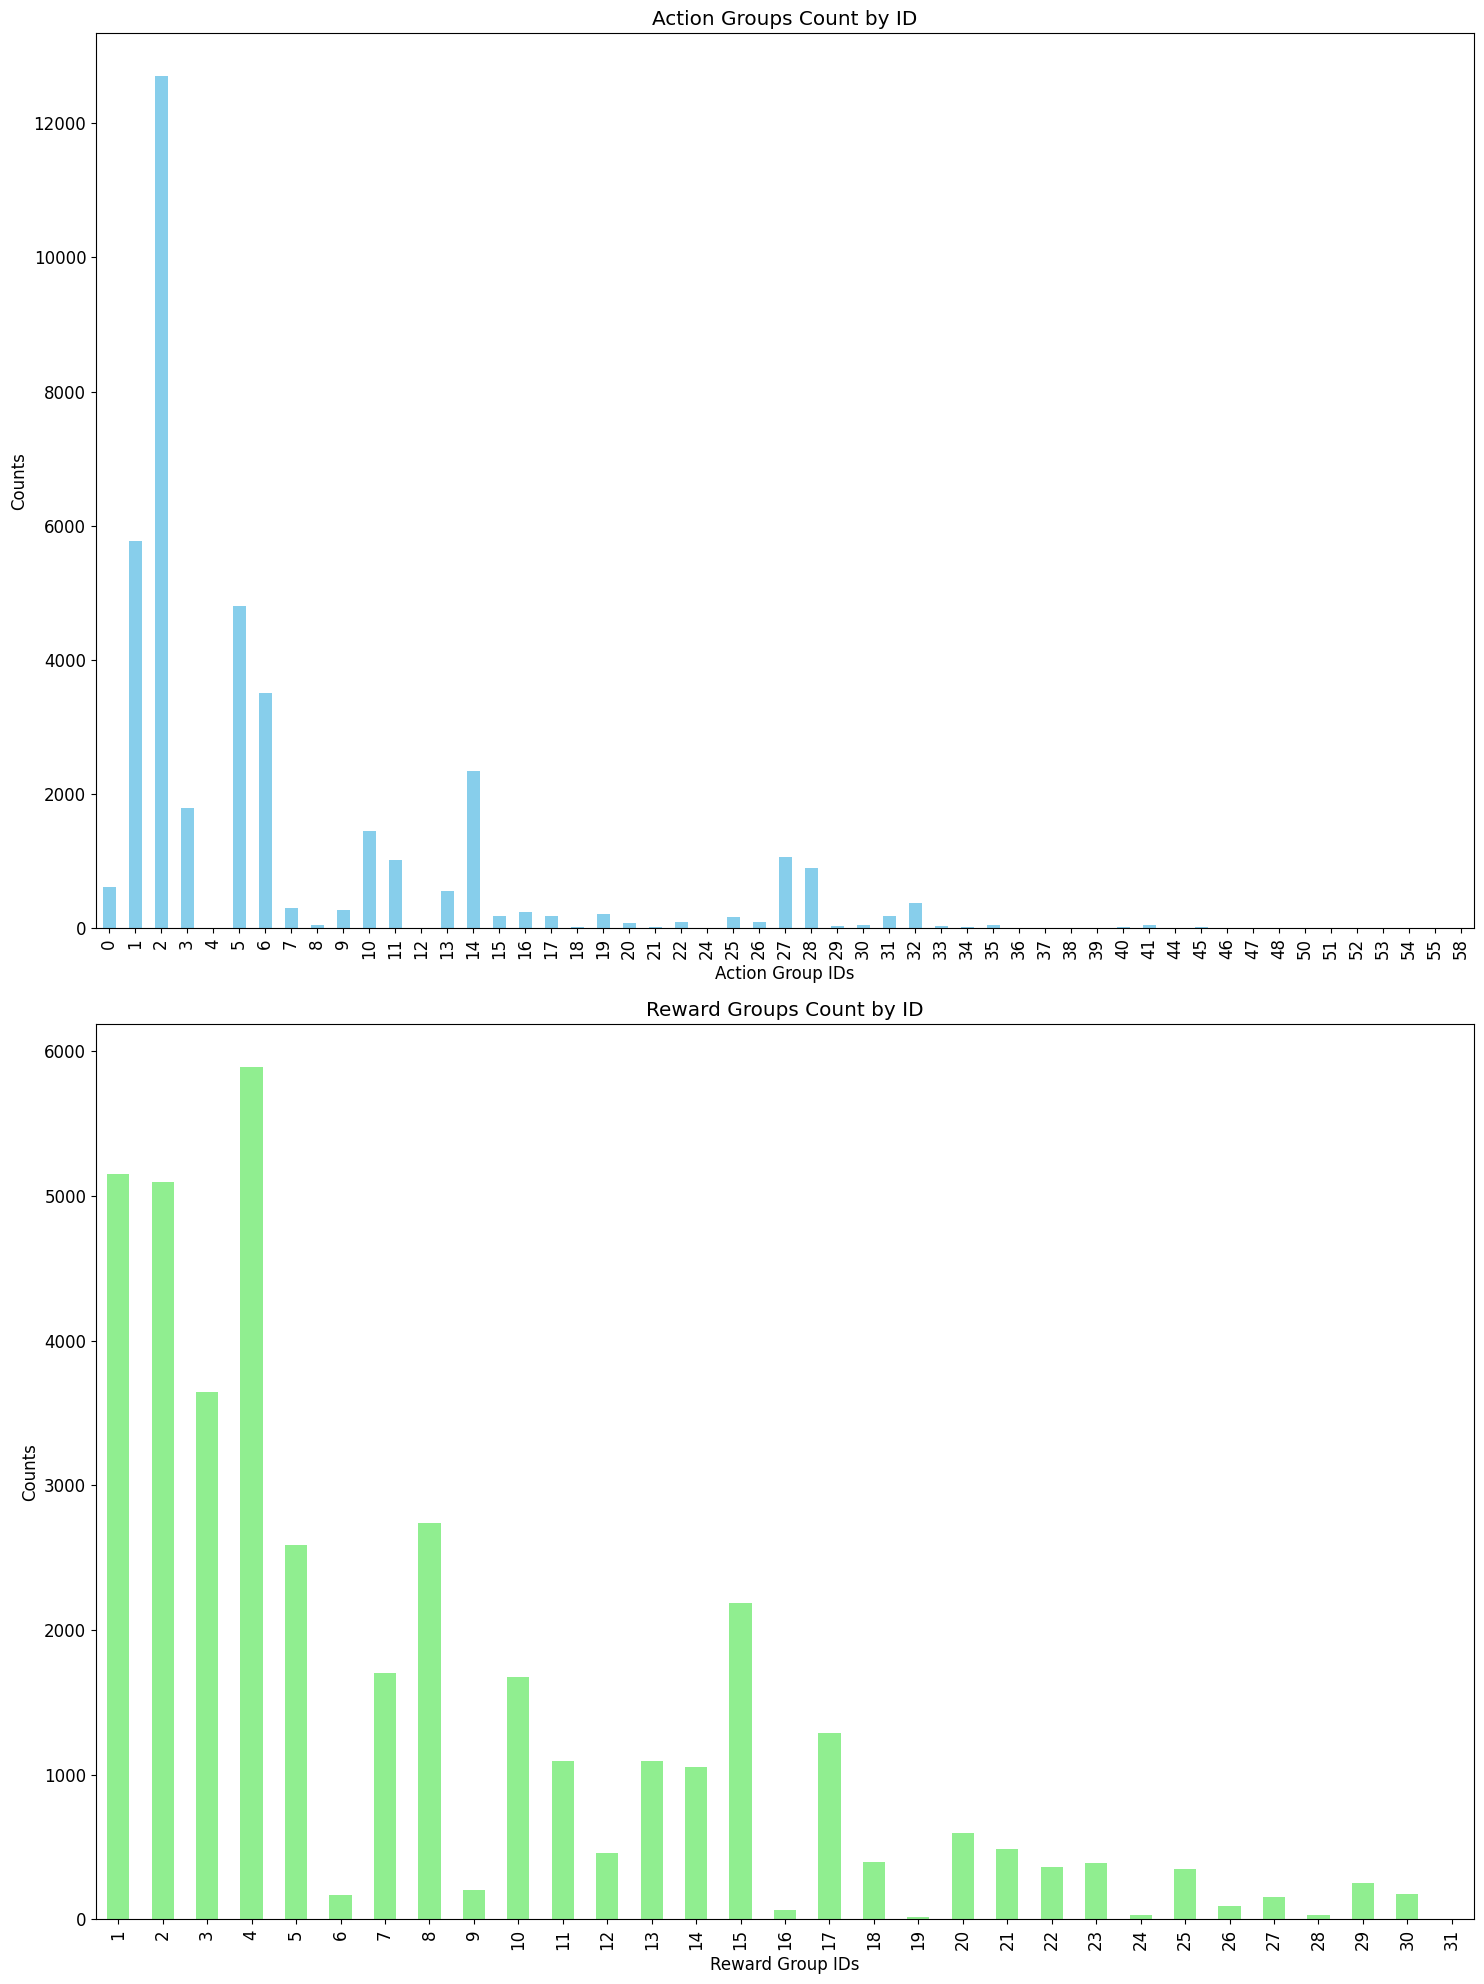

In [11]:
def plot_histograms_with_ids(df):
    # Count the number of rows for each unique group ID
    action_group_id_counts = df['action_group_ids'].value_counts().sort_index()
    reward_group_id_counts = df['reward_group_id'].value_counts().sort_index()

    # Create mappings for group names to their IDs
    action_group_id_mapping = df[['action_groups', 'action_group_ids']].drop_duplicates().set_index('action_group_ids').sort_index()
    reward_group_id_mapping = df[['reward_group', 'reward_group_id']].drop_duplicates().set_index('reward_group_id').sort_index()

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(15, 20))

    # Action Groups Histogram
    action_group_id_counts.plot(kind='bar', ax=ax[0], color='skyblue')
    ax[0].set_title('Action Groups Count by ID')
    ax[0].set_xlabel('Action Group IDs')
    ax[0].set_ylabel('Counts')
    ax[0].set_xticklabels(action_group_id_counts.index)

    # Reward Group Histogram
    reward_group_id_counts.plot(kind='bar', ax=ax[1], color='lightgreen')
    ax[1].set_title('Reward Groups Count by ID')
    ax[1].set_xlabel('Reward Group IDs')
    ax[1].set_ylabel('Counts')
    ax[1].set_xticklabels(reward_group_id_counts.index)

    plt.tight_layout()
    plt.show()

    return action_group_id_mapping, reward_group_id_mapping

Unique_df = df_dataset.drop_duplicates(subset=['File_ID'], keep='last')

action_group_id_mapping, reward_group_id_mapping = plot_histograms_with_ids(Unique_df)

# Display mappings
# display(action_group_id_mapping)
# display(reward_group_id_mapping)

In [12]:
action_group_id_mapping.to_csv('../Results/Action_Group_ID_Mapping.csv')
reward_group_id_mapping.to_csv('../Results/Reward_Group_ID_Mapping.csv')
action_group_id_mapping

,action_groups
action_group_ids,
0,5~10_0.3~0.5_<5
1,10~15_0.3~0.5_<5
2,10~15_0.3~0.5_5~8
3,5~10_0.3~0.5_5~8
4,~5_0.3~0.5_<5
5,15~20_0.3~0.5_5~8
6,15~20_0.3~0.5_<5
7,10~15_0.1~0.3_5~8
8,5~10_0.1~0.3_5~8


In [13]:
# Initialize CQL algorithm
cql = DiscreteCQLConfig(
    batch_size=256, observation_scaler=StandardObservationScaler(), learning_rate = 0.01 
).create(device='cuda:0')

cql.fit(dataset, n_steps=1000000) 

2024-03-15 16:12.49 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(9,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=60)
2024-03-15 16:12.49 [debug    ] Fitting observation scaler...  observation_scaler=standard
2024-03-15 16:46.50 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20240315164650
2024-03-15 16:46.50 [debug    ] Building models...            
2024-03-15 16:46.50 [debug    ] Models have been built.       
2024-03-15 16:46.50 [info     ] Parameters                     params={'observation_shape': [9], 'action_size': 60, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'standard', 'params': {'mean': [6.149734740844974, 14.186244271648723, 0.4342922613289987, 4.709694727448951, 

Epoch 1/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 16:48.48 [info     ] DiscreteCQL_20240315164650: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00819552025794983, 'time_algorithm_update': 0.00333391375541687, 'loss': 0.25359017201662065, 'td_loss': 0.17753243999704718, 'conservative_loss': 0.07605773192290216, 'time_step': 0.011673932313919068} step=10000
2024-03-15 16:48.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_10000.d3


Epoch 2/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 16:50.44 [info     ] DiscreteCQL_20240315164650: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.00813341646194458, 'time_algorithm_update': 0.0032441372632980347, 'loss': 0.22415277972370387, 'td_loss': 0.1835301423445344, 'conservative_loss': 0.04062263729204424, 'time_step': 0.011513468003273011} step=20000
2024-03-15 16:50.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_20000.d3


Epoch 3/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 16:52.40 [info     ] DiscreteCQL_20240315164650: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.0081768474817276, 'time_algorithm_update': 0.0032687942028045655, 'loss': 0.24007573556229472, 'td_loss': 0.2039944586969912, 'conservative_loss': 0.036081276720180175, 'time_step': 0.011578572678565978} step=30000
2024-03-15 16:52.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_30000.d3


Epoch 4/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 16:54.37 [info     ] DiscreteCQL_20240315164650: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.008130639028549195, 'time_algorithm_update': 0.003293492007255554, 'loss': 0.2725813732616603, 'td_loss': 0.2387413564696908, 'conservative_loss': 0.03384001669685822, 'time_step': 0.0115618816614151} step=40000
2024-03-15 16:54.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_40000.d3


Epoch 5/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 16:56.33 [info     ] DiscreteCQL_20240315164650: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.008142118287086487, 'time_algorithm_update': 0.003258976411819458, 'loss': 0.3025664433926344, 'td_loss': 0.27136652673706413, 'conservative_loss': 0.031199916593520904, 'time_step': 0.01154284052848816} step=50000
2024-03-15 16:56.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_50000.d3


Epoch 6/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 16:58.29 [info     ] DiscreteCQL_20240315164650: epoch=6 step=60000 epoch=6 metrics={'time_sample_batch': 0.008161418890953063, 'time_algorithm_update': 0.003233884286880493, 'loss': 0.328705078291893, 'td_loss': 0.29831900042369963, 'conservative_loss': 0.030386077860242222, 'time_step': 0.01153598473072052} step=60000
2024-03-15 16:58.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_60000.d3


Epoch 7/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:00.25 [info     ] DiscreteCQL_20240315164650: epoch=7 step=70000 epoch=7 metrics={'time_sample_batch': 0.00815853841304779, 'time_algorithm_update': 0.00327741436958313, 'loss': 0.3616520970121026, 'td_loss': 0.3304872847110033, 'conservative_loss': 0.03116481225792086, 'time_step': 0.011577504420280457} step=70000
2024-03-15 17:00.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_70000.d3


Epoch 8/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:02.22 [info     ] DiscreteCQL_20240315164650: epoch=8 step=80000 epoch=8 metrics={'time_sample_batch': 0.008145242285728455, 'time_algorithm_update': 0.0032785340785980227, 'loss': 0.4132106303393841, 'td_loss': 0.38304448116347195, 'conservative_loss': 0.030166149350843625, 'time_step': 0.011564603996276856} step=80000
2024-03-15 17:02.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_80000.d3


Epoch 9/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:04.18 [info     ] DiscreteCQL_20240315164650: epoch=9 step=90000 epoch=9 metrics={'time_sample_batch': 0.008121551442146302, 'time_algorithm_update': 0.003252536416053772, 'loss': 0.4136744040220976, 'td_loss': 0.3861389660790563, 'conservative_loss': 0.027535438124794746, 'time_step': 0.011516321182250976} step=90000
2024-03-15 17:04.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_90000.d3


Epoch 10/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:06.14 [info     ] DiscreteCQL_20240315164650: epoch=10 step=100000 epoch=10 metrics={'time_sample_batch': 0.008115266752243042, 'time_algorithm_update': 0.0032527188777923583, 'loss': 0.4470456225171685, 'td_loss': 0.4188290607497096, 'conservative_loss': 0.0282165616159793, 'time_step': 0.011510017657279967} step=100000
2024-03-15 17:06.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_100000.d3


Epoch 11/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:08.10 [info     ] DiscreteCQL_20240315164650: epoch=11 step=110000 epoch=11 metrics={'time_sample_batch': 0.008174879574775695, 'time_algorithm_update': 0.003278793406486511, 'loss': 0.5134358385398984, 'td_loss': 0.4825937783434987, 'conservative_loss': 0.030842060006340034, 'time_step': 0.011597314453125} step=110000
2024-03-15 17:08.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_110000.d3


Epoch 12/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:10.07 [info     ] DiscreteCQL_20240315164650: epoch=12 step=120000 epoch=12 metrics={'time_sample_batch': 0.008221427702903747, 'time_algorithm_update': 0.0032809688091278077, 'loss': 0.5150827652424574, 'td_loss': 0.48585924105644224, 'conservative_loss': 0.02922352419317467, 'time_step': 0.011646175813674926} step=120000
2024-03-15 17:10.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_120000.d3


Epoch 13/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:12.04 [info     ] DiscreteCQL_20240315164650: epoch=13 step=130000 epoch=13 metrics={'time_sample_batch': 0.008185179352760315, 'time_algorithm_update': 0.0032810471296310425, 'loss': 0.6242897887527943, 'td_loss': 0.5942404548540712, 'conservative_loss': 0.0300493336131447, 'time_step': 0.011613782739639282} step=130000
2024-03-15 17:12.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_130000.d3


Epoch 14/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:14.03 [info     ] DiscreteCQL_20240315164650: epoch=14 step=140000 epoch=14 metrics={'time_sample_batch': 0.008296157097816467, 'time_algorithm_update': 0.0033825363636016846, 'loss': 0.5975928419351578, 'td_loss': 0.5675861924737692, 'conservative_loss': 0.030006649661174743, 'time_step': 0.011830072832107543} step=140000
2024-03-15 17:14.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_140000.d3


Epoch 15/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:16.02 [info     ] DiscreteCQL_20240315164650: epoch=15 step=150000 epoch=15 metrics={'time_sample_batch': 0.008262348580360413, 'time_algorithm_update': 0.0033676629543304445, 'loss': 0.6217312345221638, 'td_loss': 0.5913063908711076, 'conservative_loss': 0.03042484359596856, 'time_step': 0.011779337072372437} step=150000
2024-03-15 17:16.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_150000.d3


Epoch 16/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:17.58 [info     ] DiscreteCQL_20240315164650: epoch=16 step=160000 epoch=16 metrics={'time_sample_batch': 0.008129084849357605, 'time_algorithm_update': 0.003275985312461853, 'loss': 0.6420581787109375, 'td_loss': 0.6135631545513869, 'conservative_loss': 0.02849502424102975, 'time_step': 0.011551486015319825} step=160000
2024-03-15 17:17.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_160000.d3


Epoch 17/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:19.55 [info     ] DiscreteCQL_20240315164650: epoch=17 step=170000 epoch=17 metrics={'time_sample_batch': 0.008149010252952575, 'time_algorithm_update': 0.0032908222436904906, 'loss': 0.6700448630496859, 'td_loss': 0.6418740304574371, 'conservative_loss': 0.028170832673885163, 'time_step': 0.011587211465835572} step=170000
2024-03-15 17:19.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_170000.d3


Epoch 18/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:21.51 [info     ] DiscreteCQL_20240315164650: epoch=18 step=180000 epoch=18 metrics={'time_sample_batch': 0.008162240934371949, 'time_algorithm_update': 0.00327340407371521, 'loss': 0.7535421837851405, 'td_loss': 0.7221682004213333, 'conservative_loss': 0.031373983544507066, 'time_step': 0.011583900237083436} step=180000
2024-03-15 17:21.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_180000.d3


Epoch 19/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:23.51 [info     ] DiscreteCQL_20240315164650: epoch=19 step=190000 epoch=19 metrics={'time_sample_batch': 0.008232295131683349, 'time_algorithm_update': 0.0034827454805374147, 'loss': 0.7203185400933028, 'td_loss': 0.6890269053831697, 'conservative_loss': 0.03129163485117606, 'time_step': 0.011865792870521545} step=190000
2024-03-15 17:23.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_190000.d3


Epoch 20/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:25.51 [info     ] DiscreteCQL_20240315164650: epoch=20 step=200000 epoch=20 metrics={'time_sample_batch': 0.008288058876991272, 'time_algorithm_update': 0.0034517093658447268, 'loss': 0.7686315308660269, 'td_loss': 0.7381774029821158, 'conservative_loss': 0.030454127939103636, 'time_step': 0.011892471623420716} step=200000
2024-03-15 17:25.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_200000.d3


Epoch 21/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:27.47 [info     ] DiscreteCQL_20240315164650: epoch=21 step=210000 epoch=21 metrics={'time_sample_batch': 0.008168713307380676, 'time_algorithm_update': 0.003294341278076172, 'loss': 0.7643123069509864, 'td_loss': 0.7346695698693395, 'conservative_loss': 0.029642737705615582, 'time_step': 0.011613065695762634} step=210000
2024-03-15 17:27.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_210000.d3


Epoch 22/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:29.43 [info     ] DiscreteCQL_20240315164650: epoch=22 step=220000 epoch=22 metrics={'time_sample_batch': 0.008139243054389953, 'time_algorithm_update': 0.003239306664466858, 'loss': 0.7753698328003288, 'td_loss': 0.7468757521301508, 'conservative_loss': 0.0284940808072919, 'time_step': 0.011525958967208863} step=220000
2024-03-15 17:29.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_220000.d3


Epoch 23/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:31.40 [info     ] DiscreteCQL_20240315164650: epoch=23 step=230000 epoch=23 metrics={'time_sample_batch': 0.008129269099235534, 'time_algorithm_update': 0.003250545811653137, 'loss': 0.8661842879623175, 'td_loss': 0.8322195119351149, 'conservative_loss': 0.03396477629235596, 'time_step': 0.01152853946685791} step=230000
2024-03-15 17:31.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_230000.d3


Epoch 24/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:33.36 [info     ] DiscreteCQL_20240315164650: epoch=24 step=240000 epoch=24 metrics={'time_sample_batch': 0.008126406097412109, 'time_algorithm_update': 0.0032795346975326538, 'loss': 0.8454524123966694, 'td_loss': 0.8168396168708801, 'conservative_loss': 0.028612795554008336, 'time_step': 0.011552014279365539} step=240000
2024-03-15 17:33.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_240000.d3


Epoch 25/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:35.32 [info     ] DiscreteCQL_20240315164650: epoch=25 step=250000 epoch=25 metrics={'time_sample_batch': 0.00814266800880432, 'time_algorithm_update': 0.0032970829725265504, 'loss': 0.9156070751398802, 'td_loss': 0.8849381079524755, 'conservative_loss': 0.030668967510585208, 'time_step': 0.01159038438796997} step=250000
2024-03-15 17:35.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_250000.d3


Epoch 26/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:37.29 [info     ] DiscreteCQL_20240315164650: epoch=26 step=260000 epoch=26 metrics={'time_sample_batch': 0.008195042133331299, 'time_algorithm_update': 0.0032727555990219115, 'loss': 0.9910073502063751, 'td_loss': 0.9613756177335978, 'conservative_loss': 0.02963173245720682, 'time_step': 0.011615308237075806} step=260000
2024-03-15 17:37.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_260000.d3


Epoch 27/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:39.27 [info     ] DiscreteCQL_20240315164650: epoch=27 step=270000 epoch=27 metrics={'time_sample_batch': 0.008206822299957275, 'time_algorithm_update': 0.0032966437101364134, 'loss': 1.012653230908513, 'td_loss': 0.979870604851842, 'conservative_loss': 0.03278262655528961, 'time_step': 0.011650451302528382} step=270000
2024-03-15 17:39.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_270000.d3


Epoch 28/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:41.23 [info     ] DiscreteCQL_20240315164650: epoch=28 step=280000 epoch=28 metrics={'time_sample_batch': 0.008159540390968324, 'time_algorithm_update': 0.003283531379699707, 'loss': 1.0353220237404108, 'td_loss': 1.0030472150713206, 'conservative_loss': 0.032274808533489706, 'time_step': 0.011591277861595153} step=280000
2024-03-15 17:41.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_280000.d3


Epoch 29/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:43.20 [info     ] DiscreteCQL_20240315164650: epoch=29 step=290000 epoch=29 metrics={'time_sample_batch': 0.008152198576927184, 'time_algorithm_update': 0.0032905596494674683, 'loss': 1.118250107240677, 'td_loss': 1.0849169485628605, 'conservative_loss': 0.033333158897038084, 'time_step': 0.011588219213485717} step=290000
2024-03-15 17:43.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_290000.d3


Epoch 30/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:45.17 [info     ] DiscreteCQL_20240315164650: epoch=30 step=300000 epoch=30 metrics={'time_sample_batch': 0.008179333424568176, 'time_algorithm_update': 0.0033163058280944826, 'loss': 1.0778252611011268, 'td_loss': 1.0460067602574825, 'conservative_loss': 0.03181850131138926, 'time_step': 0.01164296805858612} step=300000
2024-03-15 17:45.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_300000.d3


Epoch 31/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:47.13 [info     ] DiscreteCQL_20240315164650: epoch=31 step=310000 epoch=31 metrics={'time_sample_batch': 0.008122187113761902, 'time_algorithm_update': 0.0032716427564620973, 'loss': 1.0657349695801734, 'td_loss': 1.0343686607897282, 'conservative_loss': 0.03136630890016677, 'time_step': 0.011536809396743774} step=310000
2024-03-15 17:47.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_310000.d3


Epoch 32/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:49.10 [info     ] DiscreteCQL_20240315164650: epoch=32 step=320000 epoch=32 metrics={'time_sample_batch': 0.00819950041770935, 'time_algorithm_update': 0.003280379390716553, 'loss': 1.259541405081749, 'td_loss': 1.2252464643716812, 'conservative_loss': 0.034294940308271904, 'time_step': 0.011625421714782714} step=320000
2024-03-15 17:49.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_320000.d3


Epoch 33/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:51.08 [info     ] DiscreteCQL_20240315164650: epoch=33 step=330000 epoch=33 metrics={'time_sample_batch': 0.008196891927719116, 'time_algorithm_update': 0.0033797003984451296, 'loss': 1.2569076264351606, 'td_loss': 1.2226112049132585, 'conservative_loss': 0.03429642187514109, 'time_step': 0.01172280490398407} step=330000
2024-03-15 17:51.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_330000.d3


Epoch 34/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:53.06 [info     ] DiscreteCQL_20240315164650: epoch=34 step=340000 epoch=34 metrics={'time_sample_batch': 0.0081916588306427, 'time_algorithm_update': 0.003375930571556091, 'loss': 1.2019565475970506, 'td_loss': 1.1670294960469008, 'conservative_loss': 0.03492705154623836, 'time_step': 0.011712258625030518} step=340000
2024-03-15 17:53.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_340000.d3


Epoch 35/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:55.02 [info     ] DiscreteCQL_20240315164650: epoch=35 step=350000 epoch=35 metrics={'time_sample_batch': 0.00813660979270935, 'time_algorithm_update': 0.0032865121603012086, 'loss': 1.2646468876749277, 'td_loss': 1.2311391195327044, 'conservative_loss': 0.033507768030115404, 'time_step': 0.011564619946479797} step=350000
2024-03-15 17:55.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_350000.d3


Epoch 36/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:56.59 [info     ] DiscreteCQL_20240315164650: epoch=36 step=360000 epoch=36 metrics={'time_sample_batch': 0.00812723400592804, 'time_algorithm_update': 0.00334565212726593, 'loss': 1.1784533381640911, 'td_loss': 1.1477948212385178, 'conservative_loss': 0.03065851681402419, 'time_step': 0.011616651964187623} step=360000
2024-03-15 17:56.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_360000.d3


Epoch 37/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 17:58.57 [info     ] DiscreteCQL_20240315164650: epoch=37 step=370000 epoch=37 metrics={'time_sample_batch': 0.008217245793342591, 'time_algorithm_update': 0.003308008623123169, 'loss': 1.3262252194136381, 'td_loss': 1.2933104673027993, 'conservative_loss': 0.032914752119255715, 'time_step': 0.01166856174468994} step=370000
2024-03-15 17:58.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_370000.d3


Epoch 38/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:00.53 [info     ] DiscreteCQL_20240315164650: epoch=38 step=380000 epoch=38 metrics={'time_sample_batch': 0.008124959683418274, 'time_algorithm_update': 0.0032843413591384886, 'loss': 1.446524192005396, 'td_loss': 1.4124748354077339, 'conservative_loss': 0.03404935638877796, 'time_step': 0.01155291223526001} step=380000
2024-03-15 18:00.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_380000.d3


Epoch 39/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:02.51 [info     ] DiscreteCQL_20240315164650: epoch=39 step=390000 epoch=39 metrics={'time_sample_batch': 0.008162738156318664, 'time_algorithm_update': 0.0033629792213439942, 'loss': 1.2624508881181478, 'td_loss': 1.230813526546955, 'conservative_loss': 0.03163736204532906, 'time_step': 0.011672215127944946} step=390000
2024-03-15 18:02.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_390000.d3


Epoch 40/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:04.51 [info     ] DiscreteCQL_20240315164650: epoch=40 step=400000 epoch=40 metrics={'time_sample_batch': 0.008285426211357116, 'time_algorithm_update': 0.0035151856422424316, 'loss': 1.204054808536172, 'td_loss': 1.173426714247465, 'conservative_loss': 0.03062809478818672, 'time_step': 0.011947868871688843} step=400000
2024-03-15 18:04.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_400000.d3


Epoch 41/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:06.47 [info     ] DiscreteCQL_20240315164650: epoch=41 step=410000 epoch=41 metrics={'time_sample_batch': 0.008144295978546143, 'time_algorithm_update': 0.003304637026786804, 'loss': 1.382943254956603, 'td_loss': 1.3481005434781312, 'conservative_loss': 0.03484271191703155, 'time_step': 0.011592684245109558} step=410000
2024-03-15 18:06.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_410000.d3


Epoch 42/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:08.44 [info     ] DiscreteCQL_20240315164650: epoch=42 step=420000 epoch=42 metrics={'time_sample_batch': 0.008177779364585877, 'time_algorithm_update': 0.003267188596725464, 'loss': 1.3009451407968997, 'td_loss': 1.2698388404101133, 'conservative_loss': 0.031106300884776283, 'time_step': 0.011590846562385558} step=420000
2024-03-15 18:08.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_420000.d3


Epoch 43/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:10.42 [info     ] DiscreteCQL_20240315164650: epoch=43 step=430000 epoch=43 metrics={'time_sample_batch': 0.00821112778186798, 'time_algorithm_update': 0.0033133139848709105, 'loss': 1.4176939021617174, 'td_loss': 1.3842816746860742, 'conservative_loss': 0.03341222723608371, 'time_step': 0.011671153044700622} step=430000
2024-03-15 18:10.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_430000.d3


Epoch 44/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:12.39 [info     ] DiscreteCQL_20240315164650: epoch=44 step=440000 epoch=44 metrics={'time_sample_batch': 0.008238111448287963, 'time_algorithm_update': 0.003308495259284973, 'loss': 1.3719179891735316, 'td_loss': 1.3408953327775002, 'conservative_loss': 0.031022656749375165, 'time_step': 0.011689712858200073} step=440000
2024-03-15 18:12.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_440000.d3


Epoch 45/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:14.35 [info     ] DiscreteCQL_20240315164650: epoch=45 step=450000 epoch=45 metrics={'time_sample_batch': 0.008120457291603088, 'time_algorithm_update': 0.0032552087306976316, 'loss': 1.4964629981011153, 'td_loss': 1.4638516371011734, 'conservative_loss': 0.032611360620427875, 'time_step': 0.011520597887039184} step=450000
2024-03-15 18:14.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_450000.d3


Epoch 46/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:16.31 [info     ] DiscreteCQL_20240315164650: epoch=46 step=460000 epoch=46 metrics={'time_sample_batch': 0.008135727834701538, 'time_algorithm_update': 0.0032533260107040405, 'loss': 1.3796936526268722, 'td_loss': 1.347282044646144, 'conservative_loss': 0.03241160780764185, 'time_step': 0.01153248155117035} step=460000
2024-03-15 18:16.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_460000.d3


Epoch 47/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:18.29 [info     ] DiscreteCQL_20240315164650: epoch=47 step=470000 epoch=47 metrics={'time_sample_batch': 0.008239235973358154, 'time_algorithm_update': 0.003299968934059143, 'loss': 1.577468265977502, 'td_loss': 1.5432854913175107, 'conservative_loss': 0.03418277519999537, 'time_step': 0.011687759590148925} step=470000
2024-03-15 18:18.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_470000.d3


Epoch 48/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:20.25 [info     ] DiscreteCQL_20240315164650: epoch=48 step=480000 epoch=48 metrics={'time_sample_batch': 0.008128022909164428, 'time_algorithm_update': 0.0032594698190689087, 'loss': 1.4577000101834536, 'td_loss': 1.4237856134533882, 'conservative_loss': 0.033914396631962156, 'time_step': 0.011532479333877563} step=480000
2024-03-15 18:20.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_480000.d3


Epoch 49/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:22.21 [info     ] DiscreteCQL_20240315164650: epoch=49 step=490000 epoch=49 metrics={'time_sample_batch': 0.00812884578704834, 'time_algorithm_update': 0.003252159285545349, 'loss': 1.4403038459479809, 'td_loss': 1.4045130188286306, 'conservative_loss': 0.03579082772870315, 'time_step': 0.011525270915031433} step=490000
2024-03-15 18:22.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_490000.d3


Epoch 50/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:24.18 [info     ] DiscreteCQL_20240315164650: epoch=50 step=500000 epoch=50 metrics={'time_sample_batch': 0.008170291113853454, 'time_algorithm_update': 0.0032724915981292724, 'loss': 1.5671554427295924, 'td_loss': 1.533881985089183, 'conservative_loss': 0.033273458300810306, 'time_step': 0.011585252141952515} step=500000
2024-03-15 18:24.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_500000.d3


Epoch 51/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:26.15 [info     ] DiscreteCQL_20240315164650: epoch=51 step=510000 epoch=51 metrics={'time_sample_batch': 0.008188077449798584, 'time_algorithm_update': 0.0033087243795394895, 'loss': 1.5632998588383198, 'td_loss': 1.5283818801403046, 'conservative_loss': 0.034917979298043064, 'time_step': 0.011642267346382141} step=510000
2024-03-15 18:26.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_510000.d3


Epoch 52/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:28.11 [info     ] DiscreteCQL_20240315164650: epoch=52 step=520000 epoch=52 metrics={'time_sample_batch': 0.008121453070640564, 'time_algorithm_update': 0.0032755685806274415, 'loss': 1.4854287417352199, 'td_loss': 1.454176791933179, 'conservative_loss': 0.031251949450338726, 'time_step': 0.011539647340774535} step=520000
2024-03-15 18:28.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_520000.d3


Epoch 53/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:30.08 [info     ] DiscreteCQL_20240315164650: epoch=53 step=530000 epoch=53 metrics={'time_sample_batch': 0.008197069692611695, 'time_algorithm_update': 0.003277354645729065, 'loss': 1.4914069704085589, 'td_loss': 1.4589765461832285, 'conservative_loss': 0.03243042450703215, 'time_step': 0.011617894792556763} step=530000
2024-03-15 18:30.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_530000.d3


Epoch 54/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:32.03 [info     ] DiscreteCQL_20240315164650: epoch=54 step=540000 epoch=54 metrics={'time_sample_batch': 0.008098913955688477, 'time_algorithm_update': 0.0032434382677078246, 'loss': 1.4676161767691374, 'td_loss': 1.4353484537184238, 'conservative_loss': 0.03226772277118871, 'time_step': 0.01148061797618866} step=540000
2024-03-15 18:32.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_540000.d3


Epoch 55/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:34.00 [info     ] DiscreteCQL_20240315164650: epoch=55 step=550000 epoch=55 metrics={'time_sample_batch': 0.008172882676124572, 'time_algorithm_update': 0.0032645708322525026, 'loss': 1.5363739161789418, 'td_loss': 1.5023726866036653, 'conservative_loss': 0.03400122939234134, 'time_step': 0.011580359029769897} step=550000
2024-03-15 18:34.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_550000.d3


Epoch 56/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:35.55 [info     ] DiscreteCQL_20240315164650: epoch=56 step=560000 epoch=56 metrics={'time_sample_batch': 0.008085965061187745, 'time_algorithm_update': 0.003222599720954895, 'loss': 1.668864526861906, 'td_loss': 1.6333830410212278, 'conservative_loss': 0.03548148593136575, 'time_step': 0.011449646353721619} step=560000
2024-03-15 18:35.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_560000.d3


Epoch 57/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:37.49 [info     ] DiscreteCQL_20240315164650: epoch=57 step=570000 epoch=57 metrics={'time_sample_batch': 0.008021898984909058, 'time_algorithm_update': 0.003151824903488159, 'loss': 1.5125446572244168, 'td_loss': 1.4796583281219005, 'conservative_loss': 0.03288632888071006, 'time_step': 0.011293305087089539} step=570000
2024-03-15 18:37.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_570000.d3


Epoch 58/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:39.45 [info     ] DiscreteCQL_20240315164650: epoch=58 step=580000 epoch=58 metrics={'time_sample_batch': 0.008125322914123535, 'time_algorithm_update': 0.0032602526903152467, 'loss': 1.5349977115392686, 'td_loss': 1.503661849039793, 'conservative_loss': 0.03133586238438729, 'time_step': 0.011527622818946839} step=580000
2024-03-15 18:39.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_580000.d3


Epoch 59/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:41.41 [info     ] DiscreteCQL_20240315164650: epoch=59 step=590000 epoch=59 metrics={'time_sample_batch': 0.008175148677825927, 'time_algorithm_update': 0.003257334089279175, 'loss': 1.782131945925951, 'td_loss': 1.7457647255271673, 'conservative_loss': 0.03636722120619379, 'time_step': 0.011580647087097167} step=590000
2024-03-15 18:41.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_590000.d3


Epoch 60/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:43.38 [info     ] DiscreteCQL_20240315164650: epoch=60 step=600000 epoch=60 metrics={'time_sample_batch': 0.008183895874023437, 'time_algorithm_update': 0.003276943039894104, 'loss': 1.8686343760520219, 'td_loss': 1.832934350991249, 'conservative_loss': 0.03570002572793164, 'time_step': 0.011607781958580017} step=600000
2024-03-15 18:43.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_600000.d3


Epoch 61/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:45.34 [info     ] DiscreteCQL_20240315164650: epoch=61 step=610000 epoch=61 metrics={'time_sample_batch': 0.008131823563575745, 'time_algorithm_update': 0.0032603641271591187, 'loss': 1.7484721414208413, 'td_loss': 1.7099595962166787, 'conservative_loss': 0.03851254496327601, 'time_step': 0.011535480332374573} step=610000
2024-03-15 18:45.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_610000.d3


Epoch 62/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:47.31 [info     ] DiscreteCQL_20240315164650: epoch=62 step=620000 epoch=62 metrics={'time_sample_batch': 0.008166467237472535, 'time_algorithm_update': 0.0032659698963165285, 'loss': 1.9697371794104577, 'td_loss': 1.9327420644581317, 'conservative_loss': 0.03699511343872873, 'time_step': 0.011580449032783508} step=620000
2024-03-15 18:47.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_620000.d3


Epoch 63/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:49.26 [info     ] DiscreteCQL_20240315164650: epoch=63 step=630000 epoch=63 metrics={'time_sample_batch': 0.008115686583518982, 'time_algorithm_update': 0.003238373374938965, 'loss': 1.708410402649641, 'td_loss': 1.6756737395823003, 'conservative_loss': 0.03273666267094668, 'time_step': 0.011497484397888183} step=630000
2024-03-15 18:49.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_630000.d3


Epoch 64/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:51.22 [info     ] DiscreteCQL_20240315164650: epoch=64 step=640000 epoch=64 metrics={'time_sample_batch': 0.00814490556716919, 'time_algorithm_update': 0.0032346177101135252, 'loss': 1.9874759292662143, 'td_loss': 1.9482306251347066, 'conservative_loss': 0.0392453034553444, 'time_step': 0.01152527928352356} step=640000
2024-03-15 18:51.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_640000.d3


Epoch 65/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:53.18 [info     ] DiscreteCQL_20240315164650: epoch=65 step=650000 epoch=65 metrics={'time_sample_batch': 0.00812642719745636, 'time_algorithm_update': 0.0032616164684295653, 'loss': 1.5752430131196975, 'td_loss': 1.5449330434769393, 'conservative_loss': 0.03030996871312964, 'time_step': 0.011528204131126403} step=650000
2024-03-15 18:53.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_650000.d3


Epoch 66/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:55.16 [info     ] DiscreteCQL_20240315164650: epoch=66 step=660000 epoch=66 metrics={'time_sample_batch': 0.008224092650413514, 'time_algorithm_update': 0.0033074814796447754, 'loss': 1.7955609825789929, 'td_loss': 1.7596737768530846, 'conservative_loss': 0.03588720547198318, 'time_step': 0.011680650568008422} step=660000
2024-03-15 18:55.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_660000.d3


Epoch 67/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:57.13 [info     ] DiscreteCQL_20240315164650: epoch=67 step=670000 epoch=67 metrics={'time_sample_batch': 0.008177841830253602, 'time_algorithm_update': 0.003253865647315979, 'loss': 1.7366377866983413, 'td_loss': 1.7030525240063668, 'conservative_loss': 0.033585263573925474, 'time_step': 0.011576426100730897} step=670000
2024-03-15 18:57.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_670000.d3


Epoch 68/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 18:59.08 [info     ] DiscreteCQL_20240315164650: epoch=68 step=680000 epoch=68 metrics={'time_sample_batch': 0.008148389220237732, 'time_algorithm_update': 0.0032113216876983645, 'loss': 2.478361507177353, 'td_loss': 2.4364688896119593, 'conservative_loss': 0.041892617887782396, 'time_step': 0.011507992553710938} step=680000
2024-03-15 18:59.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_680000.d3


Epoch 69/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:01.05 [info     ] DiscreteCQL_20240315164650: epoch=69 step=690000 epoch=69 metrics={'time_sample_batch': 0.00816948103904724, 'time_algorithm_update': 0.003286105728149414, 'loss': 2.485605747461319, 'td_loss': 2.4425514844954015, 'conservative_loss': 0.043054262080730404, 'time_step': 0.011607702493667603} step=690000
2024-03-15 19:01.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_690000.d3


Epoch 70/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:03.02 [info     ] DiscreteCQL_20240315164650: epoch=70 step=700000 epoch=70 metrics={'time_sample_batch': 0.008195624327659606, 'time_algorithm_update': 0.003275171160697937, 'loss': 2.0474108667552473, 'td_loss': 2.011980031621456, 'conservative_loss': 0.03543083439529873, 'time_step': 0.011618309545516967} step=700000
2024-03-15 19:03.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_700000.d3


Epoch 71/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:04.59 [info     ] DiscreteCQL_20240315164650: epoch=71 step=710000 epoch=71 metrics={'time_sample_batch': 0.008171505641937256, 'time_algorithm_update': 0.003285291838645935, 'loss': 1.955776408880949, 'td_loss': 1.920988694560528, 'conservative_loss': 0.034787713523081035, 'time_step': 0.011603880405426025} step=710000
2024-03-15 19:04.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_710000.d3


Epoch 72/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:06.55 [info     ] DiscreteCQL_20240315164650: epoch=72 step=720000 epoch=72 metrics={'time_sample_batch': 0.008138041734695435, 'time_algorithm_update': 0.0032576918125152587, 'loss': 1.8994316592991352, 'td_loss': 1.8641177336752415, 'conservative_loss': 0.03531392536209314, 'time_step': 0.01154237904548645} step=720000
2024-03-15 19:06.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_720000.d3


Epoch 73/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:08.52 [info     ] DiscreteCQL_20240315164650: epoch=73 step=730000 epoch=73 metrics={'time_sample_batch': 0.008230166745185853, 'time_algorithm_update': 0.0032831825017929075, 'loss': 2.0761857697308064, 'td_loss': 2.038763805115223, 'conservative_loss': 0.03742196451169438, 'time_step': 0.011658967137336732} step=730000
2024-03-15 19:08.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_730000.d3


Epoch 74/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:10.49 [info     ] DiscreteCQL_20240315164650: epoch=74 step=740000 epoch=74 metrics={'time_sample_batch': 0.008156036639213562, 'time_algorithm_update': 0.0032533082246780395, 'loss': 1.7906738594174385, 'td_loss': 1.753907912093401, 'conservative_loss': 0.036765947139711354, 'time_step': 0.01155488727092743} step=740000
2024-03-15 19:10.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_740000.d3


Epoch 75/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:12.46 [info     ] DiscreteCQL_20240315164650: epoch=75 step=750000 epoch=75 metrics={'time_sample_batch': 0.008198498439788818, 'time_algorithm_update': 0.003302592825889587, 'loss': 1.9725811664640904, 'td_loss': 1.9361731740236283, 'conservative_loss': 0.0364079920597258, 'time_step': 0.011650944066047669} step=750000
2024-03-15 19:12.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_750000.d3


Epoch 76/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:14.43 [info     ] DiscreteCQL_20240315164650: epoch=76 step=760000 epoch=76 metrics={'time_sample_batch': 0.00815554986000061, 'time_algorithm_update': 0.003278550124168396, 'loss': 2.5857945946127177, 'td_loss': 2.545611665838957, 'conservative_loss': 0.04018293016297975, 'time_step': 0.011581337451934815} step=760000
2024-03-15 19:14.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_760000.d3


Epoch 77/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:16.39 [info     ] DiscreteCQL_20240315164650: epoch=77 step=770000 epoch=77 metrics={'time_sample_batch': 0.008155872702598571, 'time_algorithm_update': 0.003264810919761658, 'loss': 2.0628614800333978, 'td_loss': 2.0270077501773835, 'conservative_loss': 0.035853729361033766, 'time_step': 0.01156627655029297} step=770000
2024-03-15 19:16.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_770000.d3


Epoch 78/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:18.35 [info     ] DiscreteCQL_20240315164650: epoch=78 step=780000 epoch=78 metrics={'time_sample_batch': 0.00814139587879181, 'time_algorithm_update': 0.003258693599700928, 'loss': 2.575333460706472, 'td_loss': 2.5273681743383407, 'conservative_loss': 0.04796528635419672, 'time_step': 0.011551246786117554} step=780000
2024-03-15 19:18.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_780000.d3


Epoch 79/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:20.31 [info     ] DiscreteCQL_20240315164650: epoch=79 step=790000 epoch=79 metrics={'time_sample_batch': 0.00815811309814453, 'time_algorithm_update': 0.003250468158721924, 'loss': 1.8564829686284066, 'td_loss': 1.8217730774521828, 'conservative_loss': 0.034709890860051384, 'time_step': 0.011551184129714965} step=790000
2024-03-15 19:20.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_790000.d3


Epoch 80/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:22.27 [info     ] DiscreteCQL_20240315164650: epoch=80 step=800000 epoch=80 metrics={'time_sample_batch': 0.008120050740242005, 'time_algorithm_update': 0.0032614983797073366, 'loss': 1.9303510931700467, 'td_loss': 1.8928311301231384, 'conservative_loss': 0.037519963022251614, 'time_step': 0.011523528218269349} step=800000
2024-03-15 19:22.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_800000.d3


Epoch 81/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:24.24 [info     ] DiscreteCQL_20240315164650: epoch=81 step=810000 epoch=81 metrics={'time_sample_batch': 0.008202653813362121, 'time_algorithm_update': 0.003267927622795105, 'loss': 2.4836313546955586, 'td_loss': 2.442592423635721, 'conservative_loss': 0.04103893176105339, 'time_step': 0.011616242980957031} step=810000
2024-03-15 19:24.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_810000.d3


Epoch 82/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:26.23 [info     ] DiscreteCQL_20240315164650: epoch=82 step=820000 epoch=82 metrics={'time_sample_batch': 0.008212311482429504, 'time_algorithm_update': 0.0034204505681991577, 'loss': 2.6489318587899207, 'td_loss': 2.6125823539197444, 'conservative_loss': 0.036349503542878664, 'time_step': 0.011785965013504028} step=820000
2024-03-15 19:26.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_820000.d3


Epoch 83/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:28.20 [info     ] DiscreteCQL_20240315164650: epoch=83 step=830000 epoch=83 metrics={'time_sample_batch': 0.008187575578689574, 'time_algorithm_update': 0.0032795613050460816, 'loss': 2.4589305341959, 'td_loss': 2.419342522710562, 'conservative_loss': 0.039588014125882184, 'time_step': 0.01161612355709076} step=830000
2024-03-15 19:28.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_830000.d3


Epoch 84/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:30.16 [info     ] DiscreteCQL_20240315164650: epoch=84 step=840000 epoch=84 metrics={'time_sample_batch': 0.008138841366767883, 'time_algorithm_update': 0.0032989042282104493, 'loss': 1.9816359657347202, 'td_loss': 1.945723889040947, 'conservative_loss': 0.035912075633637144, 'time_step': 0.011583034229278564} step=840000
2024-03-15 19:30.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_840000.d3


Epoch 85/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:32.13 [info     ] DiscreteCQL_20240315164650: epoch=85 step=850000 epoch=85 metrics={'time_sample_batch': 0.00812513542175293, 'time_algorithm_update': 0.0032716606855392456, 'loss': 2.832907930147648, 'td_loss': 2.792318883532286, 'conservative_loss': 0.04058904669681797, 'time_step': 0.011545726704597473} step=850000
2024-03-15 19:32.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_850000.d3


Epoch 86/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:34.10 [info     ] DiscreteCQL_20240315164650: epoch=86 step=860000 epoch=86 metrics={'time_sample_batch': 0.00822779140472412, 'time_algorithm_update': 0.0032912651777267455, 'loss': 2.580876559442282, 'td_loss': 2.5402372739195824, 'conservative_loss': 0.040639285518391986, 'time_step': 0.01166778302192688} step=860000
2024-03-15 19:34.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_860000.d3


Epoch 87/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:36.08 [info     ] DiscreteCQL_20240315164650: epoch=87 step=870000 epoch=87 metrics={'time_sample_batch': 0.008157714009284974, 'time_algorithm_update': 0.0033608535051345826, 'loss': 2.495877758306265, 'td_loss': 2.4532909667670726, 'conservative_loss': 0.04258679210286355, 'time_step': 0.011669801044464112} step=870000
2024-03-15 19:36.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_870000.d3


Epoch 88/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:38.05 [info     ] DiscreteCQL_20240315164650: epoch=88 step=880000 epoch=88 metrics={'time_sample_batch': 0.008197143697738647, 'time_algorithm_update': 0.0033158371210098266, 'loss': 2.672175893265009, 'td_loss': 2.6246841648578645, 'conservative_loss': 0.047491727439616806, 'time_step': 0.011665750098228454} step=880000
2024-03-15 19:38.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_880000.d3


Epoch 89/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:40.04 [info     ] DiscreteCQL_20240315164650: epoch=89 step=890000 epoch=89 metrics={'time_sample_batch': 0.008247505903244018, 'time_algorithm_update': 0.003437164831161499, 'loss': 2.3483585846185684, 'td_loss': 2.309319618499279, 'conservative_loss': 0.03903896641945467, 'time_step': 0.01183627827167511} step=890000
2024-03-15 19:40.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_890000.d3


Epoch 90/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:42.01 [info     ] DiscreteCQL_20240315164650: epoch=90 step=900000 epoch=90 metrics={'time_sample_batch': 0.00815736436843872, 'time_algorithm_update': 0.0032749069452285766, 'loss': 3.1243328647732733, 'td_loss': 3.0788117596566678, 'conservative_loss': 0.045521104608068706, 'time_step': 0.011585872220993042} step=900000
2024-03-15 19:42.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_900000.d3


Epoch 91/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:43.57 [info     ] DiscreteCQL_20240315164650: epoch=91 step=910000 epoch=91 metrics={'time_sample_batch': 0.008137538814544678, 'time_algorithm_update': 0.0032702988386154176, 'loss': 2.557194492995739, 'td_loss': 2.517399148505926, 'conservative_loss': 0.03979534547716612, 'time_step': 0.01155509660243988} step=910000
2024-03-15 19:43.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_910000.d3


Epoch 92/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:45.54 [info     ] DiscreteCQL_20240315164650: epoch=92 step=920000 epoch=92 metrics={'time_sample_batch': 0.008186989974975587, 'time_algorithm_update': 0.003290082621574402, 'loss': 2.2013814943253993, 'td_loss': 2.160192000961304, 'conservative_loss': 0.04118949252780294, 'time_step': 0.01162627272605896} step=920000
2024-03-15 19:45.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_920000.d3


Epoch 93/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:47.52 [info     ] DiscreteCQL_20240315164650: epoch=93 step=930000 epoch=93 metrics={'time_sample_batch': 0.008257745504379273, 'time_algorithm_update': 0.003317179322242737, 'loss': 3.4319808950304984, 'td_loss': 3.38854536550045, 'conservative_loss': 0.04343552855338203, 'time_step': 0.01172796320915222} step=930000
2024-03-15 19:47.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_930000.d3


Epoch 94/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:49.49 [info     ] DiscreteCQL_20240315164650: epoch=94 step=940000 epoch=94 metrics={'time_sample_batch': 0.008211124682426452, 'time_algorithm_update': 0.0032686264753341676, 'loss': 3.436326255881786, 'td_loss': 3.383771738028526, 'conservative_loss': 0.05255451829130761, 'time_step': 0.011628651380538941} step=940000
2024-03-15 19:49.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_940000.d3


Epoch 95/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:51.45 [info     ] DiscreteCQL_20240315164650: epoch=95 step=950000 epoch=95 metrics={'time_sample_batch': 0.008132152676582337, 'time_algorithm_update': 0.003249437665939331, 'loss': 2.7320260592341423, 'td_loss': 2.686070320403576, 'conservative_loss': 0.04595573919843882, 'time_step': 0.011528497290611266} step=950000
2024-03-15 19:51.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_950000.d3


Epoch 96/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:53.41 [info     ] DiscreteCQL_20240315164650: epoch=96 step=960000 epoch=96 metrics={'time_sample_batch': 0.008136879897117614, 'time_algorithm_update': 0.003258639097213745, 'loss': 2.942004340094328, 'td_loss': 2.8897768446922303, 'conservative_loss': 0.05222749557544012, 'time_step': 0.011545264863967895} step=960000
2024-03-15 19:53.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_960000.d3


Epoch 97/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:55.38 [info     ] DiscreteCQL_20240315164650: epoch=97 step=970000 epoch=97 metrics={'time_sample_batch': 0.008159671592712402, 'time_algorithm_update': 0.00325196738243103, 'loss': 3.255711327600479, 'td_loss': 3.2118859844863414, 'conservative_loss': 0.043825341885327364, 'time_step': 0.011563458704948425} step=970000
2024-03-15 19:55.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_970000.d3


Epoch 98/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:57.35 [info     ] DiscreteCQL_20240315164650: epoch=98 step=980000 epoch=98 metrics={'time_sample_batch': 0.008157874703407288, 'time_algorithm_update': 0.003310744023323059, 'loss': 2.59184673460722, 'td_loss': 2.551290471601486, 'conservative_loss': 0.040556263237528034, 'time_step': 0.011617664575576782} step=980000
2024-03-15 19:57.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_980000.d3


Epoch 99/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 19:59.31 [info     ] DiscreteCQL_20240315164650: epoch=99 step=990000 epoch=99 metrics={'time_sample_batch': 0.00815896542072296, 'time_algorithm_update': 0.0032990857362747194, 'loss': 2.3872065797924997, 'td_loss': 2.348448218536377, 'conservative_loss': 0.038758361059171145, 'time_step': 0.01160456829071045} step=990000
2024-03-15 19:59.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_990000.d3


Epoch 100/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 20:01.28 [info     ] DiscreteCQL_20240315164650: epoch=100 step=1000000 epoch=100 metrics={'time_sample_batch': 0.008130430793762206, 'time_algorithm_update': 0.003267143702507019, 'loss': 2.329684443795681, 'td_loss': 2.2864943331003187, 'conservative_loss': 0.04319011038157623, 'time_step': 0.011545278215408326} step=1000000
2024-03-15 20:01.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240315164650/model_1000000.d3


[(1,
  {'time_sample_batch': 0.00819552025794983,
   'time_algorithm_update': 0.00333391375541687,
   'loss': 0.25359017201662065,
   'td_loss': 0.17753243999704718,
   'conservative_loss': 0.07605773192290216,
   'time_step': 0.011673932313919068}),
 (2,
  {'time_sample_batch': 0.00813341646194458,
   'time_algorithm_update': 0.0032441372632980347,
   'loss': 0.22415277972370387,
   'td_loss': 0.1835301423445344,
   'conservative_loss': 0.04062263729204424,
   'time_step': 0.011513468003273011}),
 (3,
  {'time_sample_batch': 0.0081768474817276,
   'time_algorithm_update': 0.0032687942028045655,
   'loss': 0.24007573556229472,
   'td_loss': 0.2039944586969912,
   'conservative_loss': 0.036081276720180175,
   'time_step': 0.011578572678565978}),
 (4,
  {'time_sample_batch': 0.008130639028549195,
   'time_algorithm_update': 0.003293492007255554,
   'loss': 0.2725813732616603,
   'td_loss': 0.2387413564696908,
   'conservative_loss': 0.03384001669685822,
   'time_step': 0.0115618816614151

In [14]:
# Initialize FQE algorithm
fqe = DiscreteFQE(algo=cql, config=FQEConfig(), device='cuda:0')  

fqe.fit(
   dataset,
   n_steps=1000000,
   evaluators={
      'init_value': d3rlpy.metrics.InitialStateValueEstimationEvaluator(),
      'soft_opc': d3rlpy.metrics.SoftOPCEvaluator(return_threshold=-5),
   },
)

2024-03-15 20:01.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(9,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=60)
2024-03-15 20:01.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20240315200128
2024-03-15 20:01.28 [debug    ] Building models...            
2024-03-15 20:01.28 [debug    ] Models have been built.       
2024-03-15 20:01.28 [info     ] Parameters                     params={'observation_shape': [9], 'action_size': 60, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0001, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.99

Epoch 1/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 20:42.48 [info     ] DiscreteFQE_20240315200128: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.003343016719818115, 'time_algorithm_update': 0.0024650984525680544, 'loss': 2.136796063515544, 'time_step': 0.0058895977973937984, 'init_value': -137.58148193359375, 'soft_opc': -1.2399834404804722} step=10000
2024-03-15 20:42.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_10000.d3


Epoch 2/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 21:24.13 [info     ] DiscreteFQE_20240315200128: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.0033982152462005617, 'time_algorithm_update': 0.0024594472169876098, 'loss': 3.687422688961029, 'time_step': 0.005935037636756897, 'init_value': -197.82666015625, 'soft_opc': -3.171720897148191} step=20000
2024-03-15 21:24.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_20000.d3


Epoch 3/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 22:05.25 [info     ] DiscreteFQE_20240315200128: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.0033828121662139894, 'time_algorithm_update': 0.002435862946510315, 'loss': 4.068479389953613, 'time_step': 0.0059019942283630375, 'init_value': -239.9102325439453, 'soft_opc': -6.14143427452035} step=30000
2024-03-15 22:05.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_30000.d3


Epoch 4/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 22:46.48 [info     ] DiscreteFQE_20240315200128: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.0033770553827285766, 'time_algorithm_update': 0.0024013113260269166, 'loss': 4.166707247650623, 'time_step': 0.0058593831300735475, 'init_value': -224.0025177001953, 'soft_opc': -5.4937885918121765} step=40000
2024-03-15 22:46.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_40000.d3


Epoch 5/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-15 23:28.26 [info     ] DiscreteFQE_20240315200128: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.0033670586347579958, 'time_algorithm_update': 0.002422814679145813, 'loss': 4.0481837263822555, 'time_step': 0.005868826293945312, 'init_value': -221.2327117919922, 'soft_opc': -6.7043410678078885} step=50000
2024-03-15 23:28.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_50000.d3


Epoch 6/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 00:09.48 [info     ] DiscreteFQE_20240315200128: epoch=6 step=60000 epoch=6 metrics={'time_sample_batch': 0.0033642632961273194, 'time_algorithm_update': 0.0024112351179122926, 'loss': 3.407394967532158, 'time_step': 0.0058512994527816775, 'init_value': -202.1650848388672, 'soft_opc': -4.33536809578365} step=60000
2024-03-16 00:09.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_60000.d3


Epoch 7/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 00:51.15 [info     ] DiscreteFQE_20240315200128: epoch=7 step=70000 epoch=7 metrics={'time_sample_batch': 0.0033644648313522338, 'time_algorithm_update': 0.002407938456535339, 'loss': 3.2623490434288978, 'time_step': 0.0058532541513442995, 'init_value': -202.68246459960938, 'soft_opc': -0.7602369608971458} step=70000
2024-03-16 00:51.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_70000.d3


Epoch 8/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 01:32.30 [info     ] DiscreteFQE_20240315200128: epoch=8 step=80000 epoch=8 metrics={'time_sample_batch': 0.0033600100994110108, 'time_algorithm_update': 0.0023861958265304567, 'loss': 3.1487017340540886, 'time_step': 0.0058208411693573, 'init_value': -193.21656799316406, 'soft_opc': -1.516675168936274} step=80000
2024-03-16 01:32.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_80000.d3


Epoch 9/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 02:13.47 [info     ] DiscreteFQE_20240315200128: epoch=9 step=90000 epoch=9 metrics={'time_sample_batch': 0.003391025519371033, 'time_algorithm_update': 0.0024116355180740356, 'loss': 2.946549324011803, 'time_step': 0.005881233596801758, 'init_value': -183.64564514160156, 'soft_opc': -4.237298839271375} step=90000
2024-03-16 02:13.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_90000.d3


Epoch 10/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 02:55.09 [info     ] DiscreteFQE_20240315200128: epoch=10 step=100000 epoch=10 metrics={'time_sample_batch': 0.003359968614578247, 'time_algorithm_update': 0.002406792163848877, 'loss': 3.1890268607735632, 'time_step': 0.005846803259849548, 'init_value': -177.01336669921875, 'soft_opc': -4.874240258542898} step=100000
2024-03-16 02:55.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_100000.d3


Epoch 11/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 03:36.21 [info     ] DiscreteFQE_20240315200128: epoch=11 step=110000 epoch=11 metrics={'time_sample_batch': 0.0033446449756622315, 'time_algorithm_update': 0.002402285027503967, 'loss': 3.1640611941576005, 'time_step': 0.005820873117446899, 'init_value': -177.58224487304688, 'soft_opc': -4.847545332455724} step=110000
2024-03-16 03:36.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_110000.d3


Epoch 12/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 04:17.44 [info     ] DiscreteFQE_20240315200128: epoch=12 step=120000 epoch=12 metrics={'time_sample_batch': 0.0033351442337036133, 'time_algorithm_update': 0.0023869914531707763, 'loss': 3.6026187687635423, 'time_step': 0.005796966481208801, 'init_value': -167.4001007080078, 'soft_opc': -8.571585031124556} step=120000
2024-03-16 04:17.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_120000.d3


Epoch 13/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 04:58.54 [info     ] DiscreteFQE_20240315200128: epoch=13 step=130000 epoch=13 metrics={'time_sample_batch': 0.0033630145311355593, 'time_algorithm_update': 0.0024028305530548097, 'loss': 3.901102812409401, 'time_step': 0.005842313003540039, 'init_value': -172.12252807617188, 'soft_opc': -10.965812593630773} step=130000
2024-03-16 04:58.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_130000.d3


Epoch 14/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 05:40.19 [info     ] DiscreteFQE_20240315200128: epoch=14 step=140000 epoch=14 metrics={'time_sample_batch': 0.003371101713180542, 'time_algorithm_update': 0.002433880710601807, 'loss': 3.555262591767311, 'time_step': 0.0058816205501556395, 'init_value': -161.01719665527344, 'soft_opc': -6.634290164382719} step=140000
2024-03-16 05:40.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_140000.d3


Epoch 15/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 06:21.48 [info     ] DiscreteFQE_20240315200128: epoch=15 step=150000 epoch=15 metrics={'time_sample_batch': 0.0033919978618621826, 'time_algorithm_update': 0.0024237175941467285, 'loss': 3.122921844291687, 'time_step': 0.005895650219917298, 'init_value': -171.8895263671875, 'soft_opc': -4.9602153057499265} step=150000
2024-03-16 06:21.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_150000.d3


Epoch 16/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 07:03.32 [info     ] DiscreteFQE_20240315200128: epoch=16 step=160000 epoch=16 metrics={'time_sample_batch': 0.0034296478509902952, 'time_algorithm_update': 0.0024285930633544924, 'loss': 3.6733770536065102, 'time_step': 0.005937761902809143, 'init_value': -171.4960479736328, 'soft_opc': -3.1077083928243496} step=160000
2024-03-16 07:03.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_160000.d3


Epoch 17/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 07:45.02 [info     ] DiscreteFQE_20240315200128: epoch=17 step=170000 epoch=17 metrics={'time_sample_batch': 0.0034075581073760987, 'time_algorithm_update': 0.0024103154182434083, 'loss': 3.650383594942093, 'time_step': 0.005898910307884217, 'init_value': -180.86480712890625, 'soft_opc': -2.586405610563844} step=170000
2024-03-16 07:45.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_170000.d3


Epoch 18/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 08:26.25 [info     ] DiscreteFQE_20240315200128: epoch=18 step=180000 epoch=18 metrics={'time_sample_batch': 0.003352840447425842, 'time_algorithm_update': 0.002430231738090515, 'loss': 3.4444748631715774, 'time_step': 0.005861674237251282, 'init_value': -167.64285278320312, 'soft_opc': -6.8569308365522375} step=180000
2024-03-16 08:26.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_180000.d3


Epoch 19/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 09:07.59 [info     ] DiscreteFQE_20240315200128: epoch=19 step=190000 epoch=19 metrics={'time_sample_batch': 0.003355111002922058, 'time_algorithm_update': 0.002411153173446655, 'loss': 4.1573592467546465, 'time_step': 0.005836893796920776, 'init_value': -174.1526641845703, 'soft_opc': -3.4311973707609127} step=190000
2024-03-16 09:07.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_190000.d3


Epoch 20/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 09:49.27 [info     ] DiscreteFQE_20240315200128: epoch=20 step=200000 epoch=20 metrics={'time_sample_batch': 0.003399127674102783, 'time_algorithm_update': 0.0024382800579071046, 'loss': 3.8104889587879183, 'time_step': 0.005915183854103089, 'init_value': -181.36611938476562, 'soft_opc': -5.827216265883976} step=200000
2024-03-16 09:49.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_200000.d3


Epoch 21/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 10:30.44 [info     ] DiscreteFQE_20240315200128: epoch=21 step=210000 epoch=21 metrics={'time_sample_batch': 0.0033651081323623658, 'time_algorithm_update': 0.002439074921607971, 'loss': 3.868296106648445, 'time_step': 0.005876690912246704, 'init_value': -171.9549102783203, 'soft_opc': -7.682191501114858} step=210000
2024-03-16 10:30.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_210000.d3


Epoch 22/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 11:12.18 [info     ] DiscreteFQE_20240315200128: epoch=22 step=220000 epoch=22 metrics={'time_sample_batch': 0.003388276648521423, 'time_algorithm_update': 0.0024353376388549803, 'loss': 3.7210435129523276, 'time_step': 0.005898835015296936, 'init_value': -163.7584686279297, 'soft_opc': -2.4733867300113275} step=220000
2024-03-16 11:12.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_220000.d3


Epoch 23/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 11:53.52 [info     ] DiscreteFQE_20240315200128: epoch=23 step=230000 epoch=23 metrics={'time_sample_batch': 0.0033960261583328246, 'time_algorithm_update': 0.002431689810752869, 'loss': 3.748126514029503, 'time_step': 0.005903390669822693, 'init_value': -149.06826782226562, 'soft_opc': -3.664656024386744} step=230000
2024-03-16 11:53.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_230000.d3


Epoch 24/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 12:35.13 [info     ] DiscreteFQE_20240315200128: epoch=24 step=240000 epoch=24 metrics={'time_sample_batch': 0.0034161755323410033, 'time_algorithm_update': 0.0024306928634643555, 'loss': 3.622862768137455, 'time_step': 0.00592698564529419, 'init_value': -166.1852569580078, 'soft_opc': -3.5174582540626034} step=240000
2024-03-16 12:35.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_240000.d3


Epoch 25/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 13:17.08 [info     ] DiscreteFQE_20240315200128: epoch=25 step=250000 epoch=25 metrics={'time_sample_batch': 0.0033731165170669554, 'time_algorithm_update': 0.002433225893974304, 'loss': 3.552839244389534, 'time_step': 0.005881288123130798, 'init_value': -161.56654357910156, 'soft_opc': -2.6429720044422425} step=250000
2024-03-16 13:17.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_250000.d3


Epoch 26/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 13:58.43 [info     ] DiscreteFQE_20240315200128: epoch=26 step=260000 epoch=26 metrics={'time_sample_batch': 0.003403569054603577, 'time_algorithm_update': 0.002422178101539612, 'loss': 3.519459642779827, 'time_step': 0.0059041644096374515, 'init_value': -160.5821075439453, 'soft_opc': -0.14139465140522134} step=260000
2024-03-16 13:58.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_260000.d3


Epoch 27/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 14:39.59 [info     ] DiscreteFQE_20240315200128: epoch=27 step=270000 epoch=27 metrics={'time_sample_batch': 0.0033290382623672485, 'time_algorithm_update': 0.0024113196611404417, 'loss': 3.431867814218998, 'time_step': 0.005816735625267029, 'init_value': -140.2006378173828, 'soft_opc': 1.8029750031093101} step=270000
2024-03-16 14:39.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_270000.d3


Epoch 28/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 15:21.18 [info     ] DiscreteFQE_20240315200128: epoch=28 step=280000 epoch=28 metrics={'time_sample_batch': 0.0033758447647094726, 'time_algorithm_update': 0.0023975015640258788, 'loss': 3.148430556833744, 'time_step': 0.005852264738082886, 'init_value': -154.4901123046875, 'soft_opc': 0.5604220829200415} step=280000
2024-03-16 15:21.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_280000.d3


Epoch 29/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 16:02.44 [info     ] DiscreteFQE_20240315200128: epoch=29 step=290000 epoch=29 metrics={'time_sample_batch': 0.0033702621936798098, 'time_algorithm_update': 0.002418398571014404, 'loss': 3.5050713148891925, 'time_step': 0.005868235421180725, 'init_value': -156.75205993652344, 'soft_opc': -1.8159250820241652} step=290000
2024-03-16 16:02.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_290000.d3


Epoch 30/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 16:44.09 [info     ] DiscreteFQE_20240315200128: epoch=30 step=300000 epoch=30 metrics={'time_sample_batch': 0.0034070274353027344, 'time_algorithm_update': 0.002430341124534607, 'loss': 3.7037748856425283, 'time_step': 0.005917590117454529, 'init_value': -180.1149139404297, 'soft_opc': -2.877301003373532} step=300000
2024-03-16 16:44.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_300000.d3


Epoch 31/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 17:25.32 [info     ] DiscreteFQE_20240315200128: epoch=31 step=310000 epoch=31 metrics={'time_sample_batch': 0.0033659528493881225, 'time_algorithm_update': 0.0023909335374832155, 'loss': 3.658696747994423, 'time_step': 0.00583224732875824, 'init_value': -171.1314239501953, 'soft_opc': -1.6665033804665654} step=310000
2024-03-16 17:25.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_310000.d3


Epoch 32/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 18:07.00 [info     ] DiscreteFQE_20240315200128: epoch=32 step=320000 epoch=32 metrics={'time_sample_batch': 0.0033349279165267942, 'time_algorithm_update': 0.0023923810243606566, 'loss': 3.363966982114315, 'time_step': 0.0058048282384872436, 'init_value': -174.6971893310547, 'soft_opc': -0.14988984449027498} step=320000
2024-03-16 18:07.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_320000.d3


Epoch 33/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 18:48.28 [info     ] DiscreteFQE_20240315200128: epoch=33 step=330000 epoch=33 metrics={'time_sample_batch': 0.003395093822479248, 'time_algorithm_update': 0.0024439860582351684, 'loss': 3.2974128490448, 'time_step': 0.005918482112884521, 'init_value': -171.87936401367188, 'soft_opc': -1.984118790900169} step=330000
2024-03-16 18:48.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_330000.d3


Epoch 34/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 19:30.03 [info     ] DiscreteFQE_20240315200128: epoch=34 step=340000 epoch=34 metrics={'time_sample_batch': 0.003377298378944397, 'time_algorithm_update': 0.0023927945137023924, 'loss': 3.4272664501070977, 'time_step': 0.00584744553565979, 'init_value': -160.10276794433594, 'soft_opc': 0.853280051509671} step=340000
2024-03-16 19:30.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_340000.d3


Epoch 35/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 20:11.24 [info     ] DiscreteFQE_20240315200128: epoch=35 step=350000 epoch=35 metrics={'time_sample_batch': 0.0033832905530929566, 'time_algorithm_update': 0.002432651662826538, 'loss': 3.4603195749998092, 'time_step': 0.0058948894739151, 'init_value': -164.77952575683594, 'soft_opc': 2.8250933193564833} step=350000
2024-03-16 20:11.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_350000.d3


Epoch 36/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 20:53.05 [info     ] DiscreteFQE_20240315200128: epoch=36 step=360000 epoch=36 metrics={'time_sample_batch': 0.003355557560920715, 'time_algorithm_update': 0.002401793169975281, 'loss': 3.368630289512873, 'time_step': 0.005835967659950256, 'init_value': -168.09085083007812, 'soft_opc': 3.0099501692025967} step=360000
2024-03-16 20:53.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_360000.d3


Epoch 37/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 21:34.26 [info     ] DiscreteFQE_20240315200128: epoch=37 step=370000 epoch=37 metrics={'time_sample_batch': 0.0033466962337493898, 'time_algorithm_update': 0.0023859444618225096, 'loss': 3.5110375106573106, 'time_step': 0.005809589481353759, 'init_value': -168.9925994873047, 'soft_opc': 2.3163152407164773} step=370000
2024-03-16 21:34.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_370000.d3


Epoch 38/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 22:16.03 [info     ] DiscreteFQE_20240315200128: epoch=38 step=380000 epoch=38 metrics={'time_sample_batch': 0.003361301612854004, 'time_algorithm_update': 0.0024192106246948243, 'loss': 3.558044799351692, 'time_step': 0.005857291531562805, 'init_value': -177.93003845214844, 'soft_opc': 2.9031546022251575} step=380000
2024-03-16 22:16.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_380000.d3


Epoch 39/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 22:57.30 [info     ] DiscreteFQE_20240315200128: epoch=39 step=390000 epoch=39 metrics={'time_sample_batch': 0.0033491885900497438, 'time_algorithm_update': 0.002392900228500366, 'loss': 3.3947358480095864, 'time_step': 0.005821514058113098, 'init_value': -177.68223571777344, 'soft_opc': 4.1148786294117485} step=390000
2024-03-16 22:57.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_390000.d3


Epoch 40/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-16 23:38.48 [info     ] DiscreteFQE_20240315200128: epoch=40 step=400000 epoch=40 metrics={'time_sample_batch': 0.003371020317077637, 'time_algorithm_update': 0.0023984557390213015, 'loss': 3.7904721821546556, 'time_step': 0.0058477675199508665, 'init_value': -184.7725372314453, 'soft_opc': 0.5673276868750463} step=400000
2024-03-16 23:38.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_400000.d3


Epoch 41/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 00:20.22 [info     ] DiscreteFQE_20240315200128: epoch=41 step=410000 epoch=41 metrics={'time_sample_batch': 0.0033917417526245115, 'time_algorithm_update': 0.0024339027404785157, 'loss': 4.04244817738533, 'time_step': 0.005905530524253845, 'init_value': -183.16444396972656, 'soft_opc': -0.9464706401025182} step=410000
2024-03-17 00:20.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_410000.d3


Epoch 42/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 01:01.51 [info     ] DiscreteFQE_20240315200128: epoch=42 step=420000 epoch=42 metrics={'time_sample_batch': 0.0034034305572509765, 'time_algorithm_update': 0.0024495962381362916, 'loss': 4.255307114923, 'time_step': 0.00593481969833374, 'init_value': -186.20623779296875, 'soft_opc': 0.4705277252339499} step=420000
2024-03-17 01:01.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_420000.d3


Epoch 43/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 01:43.09 [info     ] DiscreteFQE_20240315200128: epoch=43 step=430000 epoch=43 metrics={'time_sample_batch': 0.0033771295547485353, 'time_algorithm_update': 0.0024288432598114015, 'loss': 4.17147192299366, 'time_step': 0.005884166240692139, 'init_value': -184.807861328125, 'soft_opc': 1.7317575463841592} step=430000
2024-03-17 01:43.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_430000.d3


Epoch 44/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 02:24.32 [info     ] DiscreteFQE_20240315200128: epoch=44 step=440000 epoch=44 metrics={'time_sample_batch': 0.0034146882057189943, 'time_algorithm_update': 0.0024650646924972534, 'loss': 4.166382351160049, 'time_step': 0.005960524415969849, 'init_value': -179.56442260742188, 'soft_opc': 0.7922924508536937} step=440000
2024-03-17 02:24.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_440000.d3


Epoch 45/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 03:06.03 [info     ] DiscreteFQE_20240315200128: epoch=45 step=450000 epoch=45 metrics={'time_sample_batch': 0.003387846302986145, 'time_algorithm_update': 0.0024762829065322874, 'loss': 3.7794214344501493, 'time_step': 0.005947139573097229, 'init_value': -167.29627990722656, 'soft_opc': 4.1352415137347975} step=450000
2024-03-17 03:06.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_450000.d3


Epoch 46/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 03:47.34 [info     ] DiscreteFQE_20240315200128: epoch=46 step=460000 epoch=46 metrics={'time_sample_batch': 0.0033890796422958373, 'time_algorithm_update': 0.0024550800561904907, 'loss': 3.686350282609463, 'time_step': 0.005920797610282898, 'init_value': -173.47216796875, 'soft_opc': -0.46302052676060157} step=460000
2024-03-17 03:47.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_460000.d3


Epoch 47/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 04:29.04 [info     ] DiscreteFQE_20240315200128: epoch=47 step=470000 epoch=47 metrics={'time_sample_batch': 0.00341396906375885, 'time_algorithm_update': 0.002434194326400757, 'loss': 4.160402981710434, 'time_step': 0.005923544239997864, 'init_value': -183.72264099121094, 'soft_opc': -1.035355396857085} step=470000
2024-03-17 04:29.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_470000.d3


Epoch 48/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 05:10.36 [info     ] DiscreteFQE_20240315200128: epoch=48 step=480000 epoch=48 metrics={'time_sample_batch': 0.0033458339214324953, 'time_algorithm_update': 0.002389898133277893, 'loss': 4.150872431433201, 'time_step': 0.005812398052215576, 'init_value': -178.65719604492188, 'soft_opc': -1.539936811488559} step=480000
2024-03-17 05:10.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_480000.d3


Epoch 49/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 05:52.15 [info     ] DiscreteFQE_20240315200128: epoch=49 step=490000 epoch=49 metrics={'time_sample_batch': 0.0033523411989212037, 'time_algorithm_update': 0.002423327445983887, 'loss': 4.188491928708554, 'time_step': 0.005851590895652771, 'init_value': -175.06781005859375, 'soft_opc': 0.4513610593500914} step=490000
2024-03-17 05:52.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_490000.d3


Epoch 50/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 06:33.38 [info     ] DiscreteFQE_20240315200128: epoch=50 step=500000 epoch=50 metrics={'time_sample_batch': 0.0033498985052108766, 'time_algorithm_update': 0.0024056792974472044, 'loss': 4.018530949854851, 'time_step': 0.005834696555137634, 'init_value': -173.6131591796875, 'soft_opc': -2.556633930730925} step=500000
2024-03-17 06:33.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_500000.d3


Epoch 51/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 07:15.03 [info     ] DiscreteFQE_20240315200128: epoch=51 step=510000 epoch=51 metrics={'time_sample_batch': 0.003349005436897278, 'time_algorithm_update': 0.002407644605636597, 'loss': 3.8919729254841804, 'time_step': 0.0058251540660858156, 'init_value': -189.638427734375, 'soft_opc': -6.000339392885252} step=510000
2024-03-17 07:15.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_510000.d3


Epoch 52/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 07:56.43 [info     ] DiscreteFQE_20240315200128: epoch=52 step=520000 epoch=52 metrics={'time_sample_batch': 0.003355144190788269, 'time_algorithm_update': 0.002422416090965271, 'loss': 3.9638527251839637, 'time_step': 0.00585565071105957, 'init_value': -177.89031982421875, 'soft_opc': -0.5948491393659765} step=520000
2024-03-17 07:56.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_520000.d3


Epoch 53/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 08:38.20 [info     ] DiscreteFQE_20240315200128: epoch=53 step=530000 epoch=53 metrics={'time_sample_batch': 0.003372226071357727, 'time_algorithm_update': 0.002401452136039734, 'loss': 3.8330154702544212, 'time_step': 0.0058476167917251584, 'init_value': -174.32363891601562, 'soft_opc': -5.541421731177877} step=530000
2024-03-17 08:38.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_530000.d3


Epoch 54/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 09:19.52 [info     ] DiscreteFQE_20240315200128: epoch=54 step=540000 epoch=54 metrics={'time_sample_batch': 0.0033464930057525637, 'time_algorithm_update': 0.0024271712064743043, 'loss': 3.796026766514778, 'time_step': 0.005852331185340881, 'init_value': -170.60693359375, 'soft_opc': -6.991295510322402} step=540000
2024-03-17 09:19.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_540000.d3


Epoch 55/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 10:01.21 [info     ] DiscreteFQE_20240315200128: epoch=55 step=550000 epoch=55 metrics={'time_sample_batch': 0.003357177472114563, 'time_algorithm_update': 0.0024000633478164675, 'loss': 3.854975585615635, 'time_step': 0.00583525013923645, 'init_value': -177.447265625, 'soft_opc': -5.518467705578075} step=550000
2024-03-17 10:01.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_550000.d3


Epoch 56/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 10:42.53 [info     ] DiscreteFQE_20240315200128: epoch=56 step=560000 epoch=56 metrics={'time_sample_batch': 0.0034103710651397705, 'time_algorithm_update': 0.0024276169300079344, 'loss': 4.105951755142212, 'time_step': 0.005913022327423096, 'init_value': -181.81622314453125, 'soft_opc': -4.00292006559269} step=560000
2024-03-17 10:42.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_560000.d3


Epoch 57/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 11:24.13 [info     ] DiscreteFQE_20240315200128: epoch=57 step=570000 epoch=57 metrics={'time_sample_batch': 0.003395304536819458, 'time_algorithm_update': 0.0024388696432113646, 'loss': 4.298467681252957, 'time_step': 0.005909958744049072, 'init_value': -187.29299926757812, 'soft_opc': -0.9830592221641155} step=570000
2024-03-17 11:24.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_570000.d3


Epoch 58/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 12:05.42 [info     ] DiscreteFQE_20240315200128: epoch=58 step=580000 epoch=58 metrics={'time_sample_batch': 0.003382846665382385, 'time_algorithm_update': 0.0024062942504882814, 'loss': 4.40665651717186, 'time_step': 0.005865260457992553, 'init_value': -197.35084533691406, 'soft_opc': -0.9896671773737467} step=580000
2024-03-17 12:05.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_580000.d3


Epoch 59/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 12:47.05 [info     ] DiscreteFQE_20240315200128: epoch=59 step=590000 epoch=59 metrics={'time_sample_batch': 0.0033735329151153566, 'time_algorithm_update': 0.0024162002325057983, 'loss': 4.5094466475367545, 'time_step': 0.005869347047805786, 'init_value': -196.546630859375, 'soft_opc': 1.6989438958119365} step=590000
2024-03-17 12:47.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_590000.d3


Epoch 60/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 13:28.34 [info     ] DiscreteFQE_20240315200128: epoch=60 step=600000 epoch=60 metrics={'time_sample_batch': 0.003403401231765747, 'time_algorithm_update': 0.002449997806549072, 'loss': 4.085293275678158, 'time_step': 0.00593133590221405, 'init_value': -177.55831909179688, 'soft_opc': 0.681924430305827} step=600000
2024-03-17 13:28.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_600000.d3


Epoch 61/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 14:09.59 [info     ] DiscreteFQE_20240315200128: epoch=61 step=610000 epoch=61 metrics={'time_sample_batch': 0.0034391918897628783, 'time_algorithm_update': 0.0024835124015808105, 'loss': 3.9381106761336326, 'time_step': 0.005997117638587951, 'init_value': -196.35865783691406, 'soft_opc': -3.577684220813154} step=610000
2024-03-17 14:09.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_610000.d3


Epoch 62/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 14:51.16 [info     ] DiscreteFQE_20240315200128: epoch=62 step=620000 epoch=62 metrics={'time_sample_batch': 0.0034034738779067995, 'time_algorithm_update': 0.00242957866191864, 'loss': 3.8195168793916703, 'time_step': 0.005912685084342956, 'init_value': -181.7989044189453, 'soft_opc': -2.0355456056924197} step=620000
2024-03-17 14:51.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_620000.d3


Epoch 63/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 15:32.41 [info     ] DiscreteFQE_20240315200128: epoch=63 step=630000 epoch=63 metrics={'time_sample_batch': 0.003344915318489075, 'time_algorithm_update': 0.0024244354486465452, 'loss': 4.201217199027538, 'time_step': 0.005846472835540771, 'init_value': -209.3337860107422, 'soft_opc': -5.471999635243122} step=630000
2024-03-17 15:32.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_630000.d3


Epoch 64/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 16:14.11 [info     ] DiscreteFQE_20240315200128: epoch=64 step=640000 epoch=64 metrics={'time_sample_batch': 0.0033542176961898805, 'time_algorithm_update': 0.0024231759548187255, 'loss': 4.427118434023857, 'time_step': 0.005856154155731201, 'init_value': -206.73866271972656, 'soft_opc': -1.115962604410015} step=640000
2024-03-17 16:14.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_640000.d3


Epoch 65/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 16:55.51 [info     ] DiscreteFQE_20240315200128: epoch=65 step=650000 epoch=65 metrics={'time_sample_batch': 0.0033884654998779296, 'time_algorithm_update': 0.0024484601497650146, 'loss': 4.334233795905114, 'time_step': 0.0059166412591934205, 'init_value': -197.34628295898438, 'soft_opc': 1.276208611985453} step=650000
2024-03-17 16:55.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_650000.d3


Epoch 66/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 17:37.26 [info     ] DiscreteFQE_20240315200128: epoch=66 step=660000 epoch=66 metrics={'time_sample_batch': 0.003402782082557678, 'time_algorithm_update': 0.0024515791416168213, 'loss': 4.077486064994335, 'time_step': 0.0059331918478012086, 'init_value': -176.19578552246094, 'soft_opc': 0.7203790181677618} step=660000
2024-03-17 17:37.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_660000.d3


Epoch 67/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 18:19.07 [info     ] DiscreteFQE_20240315200128: epoch=67 step=670000 epoch=67 metrics={'time_sample_batch': 0.0034363600730895998, 'time_algorithm_update': 0.0024599174976348876, 'loss': 3.9479402144908904, 'time_step': 0.005980328893661499, 'init_value': -176.33670043945312, 'soft_opc': -1.200781783319627} step=670000
2024-03-17 18:19.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_670000.d3


Epoch 68/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 19:00.35 [info     ] DiscreteFQE_20240315200128: epoch=68 step=680000 epoch=68 metrics={'time_sample_batch': 0.0033842760801315306, 'time_algorithm_update': 0.0024506669759750367, 'loss': 3.751967678320408, 'time_step': 0.00591455934047699, 'init_value': -179.5575714111328, 'soft_opc': 2.14474509853801} step=680000
2024-03-17 19:00.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_680000.d3


Epoch 69/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 19:41.58 [info     ] DiscreteFQE_20240315200128: epoch=69 step=690000 epoch=69 metrics={'time_sample_batch': 0.003393223237991333, 'time_algorithm_update': 0.002429934597015381, 'loss': 3.692819813501835, 'time_step': 0.005898259019851685, 'init_value': -181.0871124267578, 'soft_opc': -0.5658973483456577} step=690000
2024-03-17 19:41.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_690000.d3


Epoch 70/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 20:23.27 [info     ] DiscreteFQE_20240315200128: epoch=70 step=700000 epoch=70 metrics={'time_sample_batch': 0.0033766910791397093, 'time_algorithm_update': 0.0024107900619506836, 'loss': 3.802585138177872, 'time_step': 0.005864131546020508, 'init_value': -183.7818603515625, 'soft_opc': 1.0790307871763503} step=700000
2024-03-17 20:23.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_700000.d3


Epoch 71/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 21:04.46 [info     ] DiscreteFQE_20240315200128: epoch=71 step=710000 epoch=71 metrics={'time_sample_batch': 0.003363784623146057, 'time_algorithm_update': 0.002409803581237793, 'loss': 3.613757977747917, 'time_step': 0.00585290105342865, 'init_value': -189.33624267578125, 'soft_opc': 1.1893207955806133} step=710000
2024-03-17 21:04.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_710000.d3


Epoch 72/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 21:46.08 [info     ] DiscreteFQE_20240315200128: epoch=72 step=720000 epoch=72 metrics={'time_sample_batch': 0.0033538797855377197, 'time_algorithm_update': 0.0023975677251815795, 'loss': 3.815412395441532, 'time_step': 0.005826819252967835, 'init_value': -187.27346801757812, 'soft_opc': 4.265562044432443} step=720000
2024-03-17 21:46.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_720000.d3


Epoch 73/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 22:27.36 [info     ] DiscreteFQE_20240315200128: epoch=73 step=730000 epoch=73 metrics={'time_sample_batch': 0.0033774032592773437, 'time_algorithm_update': 0.0024183780193328857, 'loss': 3.7933116005659104, 'time_step': 0.005874145793914795, 'init_value': -178.64878845214844, 'soft_opc': 5.9510039685496565} step=730000
2024-03-17 22:27.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_730000.d3


Epoch 74/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 23:09.03 [info     ] DiscreteFQE_20240315200128: epoch=74 step=740000 epoch=74 metrics={'time_sample_batch': 0.003392874312400818, 'time_algorithm_update': 0.002425047016143799, 'loss': 3.8385210106253624, 'time_step': 0.005896384930610656, 'init_value': -179.8079071044922, 'soft_opc': 8.338483334805943} step=740000
2024-03-17 23:09.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_740000.d3


Epoch 75/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-17 23:50.35 [info     ] DiscreteFQE_20240315200128: epoch=75 step=750000 epoch=75 metrics={'time_sample_batch': 0.0033553400039672853, 'time_algorithm_update': 0.0024103301763534544, 'loss': 3.8667001343607903, 'time_step': 0.005843494153022766, 'init_value': -178.03562927246094, 'soft_opc': 8.784250180222585} step=750000
2024-03-17 23:50.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_750000.d3


Epoch 76/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 00:32.02 [info     ] DiscreteFQE_20240315200128: epoch=76 step=760000 epoch=76 metrics={'time_sample_batch': 0.003328579306602478, 'time_algorithm_update': 0.002397660183906555, 'loss': 3.8433726296305655, 'time_step': 0.005802956652641297, 'init_value': -185.6385040283203, 'soft_opc': 6.816350576601053} step=760000
2024-03-18 00:32.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_760000.d3


Epoch 77/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 01:13.27 [info     ] DiscreteFQE_20240315200128: epoch=77 step=770000 epoch=77 metrics={'time_sample_batch': 0.003359704303741455, 'time_algorithm_update': 0.002421442127227783, 'loss': 3.6241748217582703, 'time_step': 0.005859177374839783, 'init_value': -174.03807067871094, 'soft_opc': 8.692476239259776} step=770000
2024-03-18 01:13.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_770000.d3


Epoch 78/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 01:54.54 [info     ] DiscreteFQE_20240315200128: epoch=78 step=780000 epoch=78 metrics={'time_sample_batch': 0.0033526898384094238, 'time_algorithm_update': 0.002397868299484253, 'loss': 3.40456123534441, 'time_step': 0.005825410413742065, 'init_value': -171.93292236328125, 'soft_opc': 9.393233933306789} step=780000
2024-03-18 01:54.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_780000.d3


Epoch 79/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 02:36.38 [info     ] DiscreteFQE_20240315200128: epoch=79 step=790000 epoch=79 metrics={'time_sample_batch': 0.003374157643318176, 'time_algorithm_update': 0.002429607915878296, 'loss': 3.6669299788832665, 'time_step': 0.0058802108526229855, 'init_value': -176.03439331054688, 'soft_opc': 8.484762789572585} step=790000
2024-03-18 02:36.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_790000.d3


Epoch 80/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 03:18.03 [info     ] DiscreteFQE_20240315200128: epoch=80 step=800000 epoch=80 metrics={'time_sample_batch': 0.003404939818382263, 'time_algorithm_update': 0.0025165438890457155, 'loss': 3.6359905633449556, 'time_step': 0.006005358457565307, 'init_value': -183.41683959960938, 'soft_opc': 11.425708135679457} step=800000
2024-03-18 03:18.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_800000.d3


Epoch 81/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 03:59.46 [info     ] DiscreteFQE_20240315200128: epoch=81 step=810000 epoch=81 metrics={'time_sample_batch': 0.0033582259178161623, 'time_algorithm_update': 0.0023906852960586546, 'loss': 3.798150462806225, 'time_step': 0.005826346659660339, 'init_value': -204.00875854492188, 'soft_opc': 9.54205064586074} step=810000
2024-03-18 03:59.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_810000.d3


Epoch 82/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 04:41.26 [info     ] DiscreteFQE_20240315200128: epoch=82 step=820000 epoch=82 metrics={'time_sample_batch': 0.0033591228246688844, 'time_algorithm_update': 0.002422714018821716, 'loss': 3.897992976605892, 'time_step': 0.005858984494209289, 'init_value': -195.36859130859375, 'soft_opc': 9.48859395224801} step=820000
2024-03-18 04:41.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_820000.d3


Epoch 83/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 05:22.56 [info     ] DiscreteFQE_20240315200128: epoch=83 step=830000 epoch=83 metrics={'time_sample_batch': 0.003371934962272644, 'time_algorithm_update': 0.00241791512966156, 'loss': 4.1002303114175795, 'time_step': 0.005865738654136658, 'init_value': -205.75982666015625, 'soft_opc': 6.530996935708032} step=830000
2024-03-18 05:22.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_830000.d3


Epoch 84/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 06:04.27 [info     ] DiscreteFQE_20240315200128: epoch=84 step=840000 epoch=84 metrics={'time_sample_batch': 0.0033503021955490113, 'time_algorithm_update': 0.002389043402671814, 'loss': 4.285312666118145, 'time_step': 0.005810830020904541, 'init_value': -194.79808044433594, 'soft_opc': 6.302949268100207} step=840000
2024-03-18 06:04.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_840000.d3


Epoch 85/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 06:45.53 [info     ] DiscreteFQE_20240315200128: epoch=85 step=850000 epoch=85 metrics={'time_sample_batch': 0.0033657724857330323, 'time_algorithm_update': 0.002421023082733154, 'loss': 4.164751039278507, 'time_step': 0.005862017822265625, 'init_value': -204.14598083496094, 'soft_opc': 9.614522830527676} step=850000
2024-03-18 06:45.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_850000.d3


Epoch 86/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 07:27.09 [info     ] DiscreteFQE_20240315200128: epoch=86 step=860000 epoch=86 metrics={'time_sample_batch': 0.0033425100564956666, 'time_algorithm_update': 0.0023853453397750853, 'loss': 4.826156547439099, 'time_step': 0.005806605696678162, 'init_value': -224.8140106201172, 'soft_opc': 3.0504845334095023} step=860000
2024-03-18 07:27.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_860000.d3


Epoch 87/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 08:08.50 [info     ] DiscreteFQE_20240315200128: epoch=87 step=870000 epoch=87 metrics={'time_sample_batch': 0.0033900401830673217, 'time_algorithm_update': 0.002419994854927063, 'loss': 4.899292922186851, 'time_step': 0.0058924263715744015, 'init_value': -219.41622924804688, 'soft_opc': 2.283867856631872} step=870000
2024-03-18 08:08.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_870000.d3


Epoch 88/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 08:50.04 [info     ] DiscreteFQE_20240315200128: epoch=88 step=880000 epoch=88 metrics={'time_sample_batch': 0.003383444905281067, 'time_algorithm_update': 0.002413882541656494, 'loss': 4.5260936218380925, 'time_step': 0.005870005488395691, 'init_value': -219.8658905029297, 'soft_opc': 4.650964158904401} step=880000
2024-03-18 08:50.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_880000.d3


Epoch 89/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 09:31.48 [info     ] DiscreteFQE_20240315200128: epoch=89 step=890000 epoch=89 metrics={'time_sample_batch': 0.0033640627145767213, 'time_algorithm_update': 0.002403093457221985, 'loss': 4.619787867665291, 'time_step': 0.005842626667022705, 'init_value': -199.17214965820312, 'soft_opc': 10.896420539817228} step=890000
2024-03-18 09:31.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_890000.d3


Epoch 90/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 10:13.19 [info     ] DiscreteFQE_20240315200128: epoch=90 step=900000 epoch=90 metrics={'time_sample_batch': 0.0033578386068344114, 'time_algorithm_update': 0.0024285337924957275, 'loss': 3.9834203513264654, 'time_step': 0.005861138153076172, 'init_value': -201.07763671875, 'soft_opc': 4.936566281524023} step=900000
2024-03-18 10:13.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_900000.d3


Epoch 91/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 10:54.50 [info     ] DiscreteFQE_20240315200128: epoch=91 step=910000 epoch=91 metrics={'time_sample_batch': 0.0033744003295898438, 'time_algorithm_update': 0.002435515666007996, 'loss': 3.63594510576725, 'time_step': 0.005886885786056518, 'init_value': -192.49977111816406, 'soft_opc': 6.311841188673611} step=910000
2024-03-18 10:54.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_910000.d3


Epoch 92/100:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-03-18 11:36.26 [info     ] DiscreteFQE_20240315200128: epoch=92 step=920000 epoch=92 metrics={'time_sample_batch': 0.003424186038970947, 'time_algorithm_update': 0.0025141416549682616, 'loss': 3.711051479113102, 'time_step': 0.006023715138435364, 'init_value': -207.10125732421875, 'soft_opc': 8.428795516408144} step=920000
2024-03-18 11:36.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20240315200128/model_920000.d3


Epoch 93/100:   0%|          | 0/10000 [00:00<?, ?it/s]